# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

После того, как модель починилась, нужно повторить на нескольких разных
датасетах.

## Задачи

- *DONE* Повторять на двух датасетах
- *DONE* Избавиться от dabs_mean_std
- *DONE* На каждом графике отображать его датасет
- *DONE* Повторять на трёх датасетах
- *DONE* Сохранить $\mathrm{loss}(\mathrm{epoch})$ в виде графика и JSON
- *DONE* Сохранить $\mathrm{metric}(\mathrm{noise})$ в виде графика и JSON
- *DONE* $P$ in $[0, 0.01, 0.05, 0.5, 0.9, 0.99]$
- *DONE* Каждый эксперимент повторяется 10 раз
- `TODO` Accuracy/F1 Score и ROC AUC на разных графиках
- `TODO` Сохранять графики на диск
- `TODO` Выводить на графики P и номер итерации
- `TODO` Привести имена к единому виду
- `TODO` Раскомментировать параметры
- `TODO` Результат получен, всё упаковано и подписано

## Настройки

In [95]:
REPORT_DIR = "report/"

TEST_SAMPLE_SIZE = 0.2
ITERATIONS = 2
RANDOM_STATE = 23432
BATCH_SIZE = 12
EPOCHS = 1 #10
LEARNING_RATE = 0.00011
PP = [0.05, 0.5] # [0, 0.01, 0.05, 0.5, 0.9, 0.99]

NOISE_SAMPLES_COUNT = 50
NOISE_FACTORS = [
    x * 2/NOISE_SAMPLES_COUNT for x in range(NOISE_SAMPLES_COUNT)
]

In [96]:
pip install torch torchvision pandas scikit-learn 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Генерация параметров

In [97]:
from dataclasses import dataclass

@dataclass
class ExperimentParameters:
    iteration: int
    p: float

def experiment_parameters():
    for iteration in range(0, ITERATIONS):
        for p in PP:
            yield ExperimentParameters(iteration, p)


## Генерация отчёта

In [98]:
import os
import json
import torch

if not os.path.exists(REPORT_DIR):
    os.makedirs(REPORT_DIR)

report_data = {}

def append_to_report(label, data):
    report_data[label] = data

def save_report():
    path = os.path.join(REPORT_DIR, 'report.json')
    with open(path, 'w') as file:
        json.dump(report_data, file, indent=4)
    print(f"Отчёт сохранён в {path}")

## Данные

In [99]:
import torch
import torch.nn as nn
from dataclasses import dataclass

@dataclass
class LearningTask:
    criterion: object
    dtype: torch.dtype

classification_task = LearningTask(
    criterion=nn.CrossEntropyLoss(),
    dtype=torch.long
)

regression_task = LearningTask(
    criterion=nn.MSELoss(),
    dtype=torch.float
)

In [100]:
from typing import List, Tuple

import urllib.request
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

def download_csv(
    url: str,
    saved_name: str,
    features: List[str] = None
) -> pd.DataFrame:
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    file_path = os.path.join(data_dir, saved_name)

    urllib.request.urlretrieve(url, file_path)

    if features is None:
        return pd.read_csv(file_path)
    else:
        return pd.read_csv(file_path, header=None, names=features)

def dataset_from_dataframe(
    df: pd.DataFrame,
    target: str,
    y_dtype: type
) -> TensorDataset:
    X = df.drop(columns=[target]).values
    y = df[target].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=y_dtype)

    return TensorDataset(X_tensor, y_tensor)

In [101]:
def breast_cancer_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/dataspelunking/MLwR/refs/heads/master/Machine%20Learning%20with%20R%20(2nd%20Ed.)/Chapter%2003/wisc_bc_data.csv',
        saved_name='wisc_bc_data.csv'
    )

    target = 'diagnosis'

    df[target] = df[target].map({ 'M': 0, 'B': 1 })
    df = df.drop(columns=['id'])

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=classification_task.dtype
        ),
        dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=classification_task.dtype
        )
    )

In [102]:
def car_evaluation_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/mragpavank/car-evaluation-dataset/refs/heads/master/car_evaluation.csv',
        saved_name='car_evaluation.csv',
        features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    )

    target = 'class'

    df[target] = df[target].map({
        'unacc': 0,
        'acc': 1,
        'good': 2,
        'vgood': 3,
    })

    df['doors'] = df['doors'].map({
        '2': 2,
        '3': 3,
        '4': 4,
        '5more': 5
    })

    high_map = {
        'low': 0,
        'med': 1,
        'high': 2,
        'vhigh': 3
    }

    df['buying'] = df['buying'].map(high_map)
    df['safety'] = df['safety'].map(high_map)
    df['maint'] = df['maint'].map(high_map)

    df['persons'] = df['persons'].map({
        '2': 2,
        '4': 4,
        'more': 6
    })

    df['lug_boot'] = df['lug_boot'].map({
        'small': 0,
        'med': 1,
        'big': 2
    })

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )
    return (
        dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=classification_task.dtype
        ),
        dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=classification_task.dtype
        )
    )

In [103]:

def student_performance_factors_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = pd.read_csv('data/StudentPerformanceFactors.csv')

    target = 'Exam_Score'

    lmh = {
        'Low': -1,
        'Medium': 0,
        'High': +1,
    }

    yn = {
        'Yes': +1,
        'No': -1,
    }

    df = df.dropna(subset=['Teacher_Quality'])

    df['Parental_Involvement'] = df['Parental_Involvement'].map(lmh)
    df['Access_to_Resources'] = df['Access_to_Resources'].map(lmh)
    df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yn)
    df['Motivation_Level'] = df['Motivation_Level'].map(lmh)
    df['Internet_Access'] = df['Internet_Access'].map(yn)
    df['Family_Income'] = df['Family_Income'].map(lmh)
    df['Teacher_Quality'] = df['Teacher_Quality'].map(lmh)
    df['School_Type'] = df['School_Type'].map({
        'Public': +1,
        'Private': -1,
    })
    df['Peer_Influence'] = df['Peer_Influence'].map({
        'Positive': +1,
        'Neutral': 0,
        'Negative': -1,
    })
    df['Learning_Disabilities'] = df['Learning_Disabilities'].map(yn)
    df['Parental_Education_Level'] = df['Parental_Education_Level'].map({
        'Postgraduate': +3,
        'College': +2,
        'High School': +1,
    }).fillna(0)
    df['Distance_from_Home'] = df['Distance_from_Home'].map({
        'Near': +1,
        'Moderate': 0,
        'Far': -1,
    }).fillna(0)
    df['Gender'] = df['Gender'].map({
        'Female': +1,
        'Male': -1,
    }).fillna(0)

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=regression_task.dtype
        ),
        dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=regression_task.dtype
        )
    )

In [104]:
from dataclasses import dataclass

import pandas as pd
from torch.utils.data import DataLoader

@dataclass
class DatasetData:
    train_dataset: pd.DataFrame
    test_dataset: pd.DataFrame
    train_loader: DataLoader
    test_loader: DataLoader

@dataclass
class Dataset:
    name: str
    number: int
    features_count: int
    classes_count: int
    data: DatasetData

    def model_a_path(self, params: ExperimentParameters) -> str:
        return f'model-{self.number}A-c-P{params.p}_N{params.iteration}.pth'

    def model_b_path(self, params: ExperimentParameters) -> str:
        return f'model-{self.number}B-c-P{params.p}_N{params.iteration}.pth'

In [105]:

from torch.utils.data import DataLoader

def make_dataset1(batch_size: int) -> Dataset:
    train_dataset, test_dataset = breast_cancer_dataset()

    return Dataset(
        name='wisc_bc_data.csv',
        number=1,
        features_count=train_dataset[1][0].shape[0],
        classes_count=2,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset2(batch_size: int) -> Dataset:
    train_dataset, test_dataset = car_evaluation_dataset()

    return Dataset(
        name='car_evaluation.csv',
        number=2,
        features_count=train_dataset[1][0].shape[0],
        classes_count=4,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset3(batch_size: int) -> Dataset:
    train_dataset, test_dataset = student_performance_factors_dataset()

    return Dataset(
        name='StudentPerformanceFactors.csv',
        number=3,
        features_count=train_dataset[1][0].shape[0],
        classes_count=1,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

datasets = [
    make_dataset1(batch_size=12),
    make_dataset2(batch_size=12),
    make_dataset3(batch_size=12),
]


## Модели

In [106]:
import torch

class CustomBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для линейного слоя.
    """
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias

class CustomReLUBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для слоя ReLU.
    """
    @staticmethod
    def forward(ctx, p: float, input: torch.Tensor):
        ctx.save_for_backward(torch.scalar_tensor(p), input)
        return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input = ctx.saved_tensors

        grad_output = grad_output * (input > 0).float()

        # У матриц ось 0 это Y
        height = grad_output.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        diagonal_mask = diagonal_mask.unsqueeze(1).expand(-1, grad_output.size(1), -1)
        diagonal_mask = diagonal_mask.permute(0, 2, 1)

        grad_output = grad_output.unsqueeze(1) * diagonal_mask
        grad_output = grad_output.sum(dim=1)

        return None, grad_output

    
class CustomReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, p: float):
        ctx.save_for_backward(input, torch.scalar_tensor(p))
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, p, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0

        # У матриц ось 0 это Y
        bernoulli_mask = torch.bernoulli(torch.ones(grad_input.size(0)) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item()+1e-5)
        
        # Multiply grad_input with the diagonal matrix
        grad_input = diagonal_mask @ grad_input
        
        return grad_input, None
    
    
class CustomReLULayer(torch.nn.Module):
    def __init__(self, p: float):
        super(CustomReLULayer, self).__init__()
        self.p = p
        self.custom_relu_backward = CustomReLUFunction.apply

    def forward(self, x):
        return self.custom_relu_backward(x, self.p)

In [107]:


import torch.nn as nn
import torch.nn.functional as F

class RegularNetwork(nn.Module):
    """
    Нейросеть с обычными линейными слоями. Параметр `p` игнорируется.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(RegularNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class AugmentedLinearNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для линейных слоёв.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.p = p

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(self.p, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(self.p, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class AugmentedReLUNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для функции активации.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_relu1 = CustomReLULayer(p)
        self.custom_relu2 = CustomReLULayer(p)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.custom_relu1(x)
        x = self.fc2(x)
        x = self.custom_relu2(x)
        x = self.fc3(x)
        return x



## Обучение

In [108]:
import torch

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())

In [109]:
import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def train(
    model: RegularNetwork, 
    dataset: Dataset,
    epochs: int,
    params: ExperimentParameters,
    criterion,
    optimizer
):
    # Наблюдаемые величины
    running_losses: list[float] = []
    fc1_dabs_mean: list[float] = []
    fc1_dabs_std: list[float] = []
    fc2_dabs_mean: list[float] = []
    fc2_dabs_std: list[float] = []
    fc3_dabs_mean: list[float] = []
    fc3_dabs_std: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(dataset.data.train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            fc1_weight = model.fc1.weight.clone()
            fc2_weight = model.fc2.weight.clone()
            fc3_weight = model.fc3.weight.clone()

            optimizer.step()

            running_loss += loss.item()

            #if i % 2 == 1:
            if True:
                (mean1, std1) = (dabs_mean_std(fc1_weight, model.fc1.weight))
                fc1_dabs_mean.append(mean1)
                fc1_dabs_std.append(std1)

                (mean2, std2) = (dabs_mean_std(fc2_weight, model.fc2.weight))
                fc2_dabs_mean.append(mean2)
                fc2_dabs_std.append(std2)

                (mean3, std3) = (dabs_mean_std(fc3_weight, model.fc3.weight))
                fc3_dabs_mean.append(mean3)
                fc3_dabs_std.append(std3)

                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(dataset.data.train_loader)} Loss={running_loss / 100:.4f}')
                running_losses.append(running_loss)
                running_loss = 0.0

    append_to_report(
        f'loss_{type(model).__name__}_{dataset.name}_p{params.p}_N{params.iteration}',
        running_losses
    )

    ## PLOTTING
    # XXX Separate plottig from training

    # def plot_mean_std(label, color, series_mean, series_std):
    #     plt.plot(X, series_mean, label=label, color=color)

    #     plt.fill_between(
    #         X,
    #         [m - s for m, s in zip(series_mean, series_std)],
    #         [m + s for m, s in zip(series_mean, series_std)],
    #         color=color,
    #         alpha=0.2
    #     )

    # Plot absolute means of gradients

    # plt.figure(figsize=(10, 6))
    # plot_mean_std('FC1 abs mean gradient', 'blue', fc1_dabs_mean, fc1_dabs_std)
    # plot_mean_std('FC2 abs mean gradient', 'green', fc2_dabs_mean, fc2_dabs_std)
    # plot_mean_std('FC3 abs mean gradient', 'red', fc3_dabs_mean, fc3_dabs_std)
    # plt.title(f'Absolute mean gradients of layers: {model.__class__.__name__}')
    # plt.legend()
    # plt.show()

    X = range(len(fc1_dabs_mean))

    plt.figure(figsize=(10, 6))
    plt.plot(X, running_losses, label='Running loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'Loss curve: {model.__class__.__name__} on {dataset.name}')
    plt.legend()
    plt.show()


E1/1 S1/38 Loss=0.7624
E1/1 S2/38 Loss=0.2735
E1/1 S3/38 Loss=0.0952
E1/1 S4/38 Loss=0.1982
E1/1 S5/38 Loss=0.3507
E1/1 S6/38 Loss=0.2133
E1/1 S7/38 Loss=0.1464
E1/1 S8/38 Loss=0.0546
E1/1 S9/38 Loss=0.0001
E1/1 S10/38 Loss=0.0806
E1/1 S11/38 Loss=0.0808
E1/1 S12/38 Loss=0.1580
E1/1 S13/38 Loss=0.1971
E1/1 S14/38 Loss=0.0044
E1/1 S15/38 Loss=0.0224
E1/1 S16/38 Loss=0.0211
E1/1 S17/38 Loss=0.0978
E1/1 S18/38 Loss=0.1224
E1/1 S19/38 Loss=0.1008
E1/1 S20/38 Loss=0.0723
E1/1 S21/38 Loss=0.0177
E1/1 S22/38 Loss=0.0000
E1/1 S23/38 Loss=0.0015
E1/1 S24/38 Loss=0.0930
E1/1 S25/38 Loss=0.1698
E1/1 S26/38 Loss=0.0686
E1/1 S27/38 Loss=0.0002
E1/1 S28/38 Loss=0.0025
E1/1 S29/38 Loss=0.0014
E1/1 S30/38 Loss=0.0664
E1/1 S31/38 Loss=0.0601
E1/1 S32/38 Loss=0.0189
E1/1 S33/38 Loss=0.0364
E1/1 S34/38 Loss=0.0024
E1/1 S35/38 Loss=0.0256
E1/1 S36/38 Loss=0.0000
E1/1 S37/38 Loss=0.0000
E1/1 S38/38 Loss=0.0823


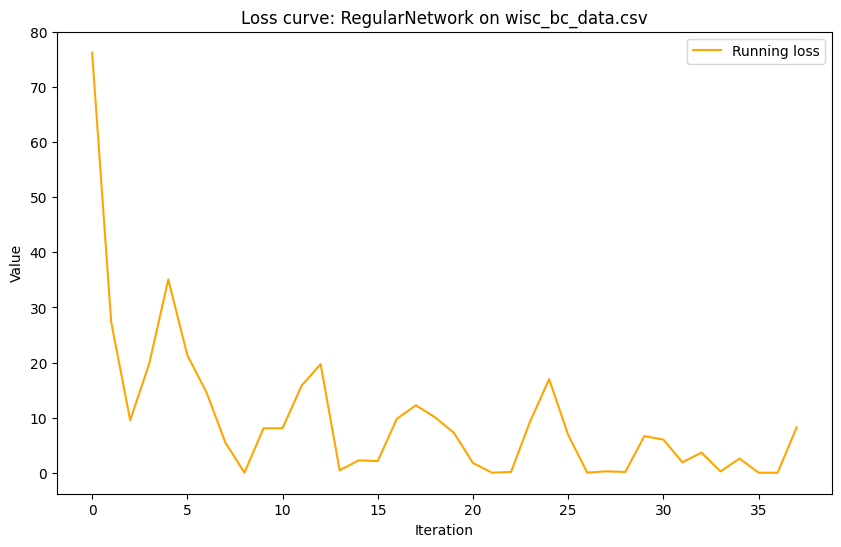

E1/1 S1/38 Loss=0.1028
E1/1 S2/38 Loss=0.4703
E1/1 S3/38 Loss=0.1161
E1/1 S4/38 Loss=0.0901
E1/1 S5/38 Loss=0.2238
E1/1 S6/38 Loss=0.2143
E1/1 S7/38 Loss=0.1142
E1/1 S8/38 Loss=0.0707
E1/1 S9/38 Loss=0.0415
E1/1 S10/38 Loss=0.0074
E1/1 S11/38 Loss=0.0373
E1/1 S12/38 Loss=0.0781
E1/1 S13/38 Loss=0.0556
E1/1 S14/38 Loss=0.0083
E1/1 S15/38 Loss=0.0233
E1/1 S16/38 Loss=0.0459
E1/1 S17/38 Loss=0.0434
E1/1 S18/38 Loss=0.0163
E1/1 S19/38 Loss=0.0066
E1/1 S20/38 Loss=0.0696
E1/1 S21/38 Loss=0.0317
E1/1 S22/38 Loss=0.0000
E1/1 S23/38 Loss=0.0067
E1/1 S24/38 Loss=0.0121
E1/1 S25/38 Loss=0.0218
E1/1 S26/38 Loss=0.0251
E1/1 S27/38 Loss=0.0327
E1/1 S28/38 Loss=0.0130
E1/1 S29/38 Loss=0.0012
E1/1 S30/38 Loss=0.0001
E1/1 S31/38 Loss=0.0150
E1/1 S32/38 Loss=0.0000
E1/1 S33/38 Loss=0.0158
E1/1 S34/38 Loss=0.0359
E1/1 S35/38 Loss=0.0001
E1/1 S36/38 Loss=0.0000
E1/1 S37/38 Loss=0.0103
E1/1 S38/38 Loss=0.0039


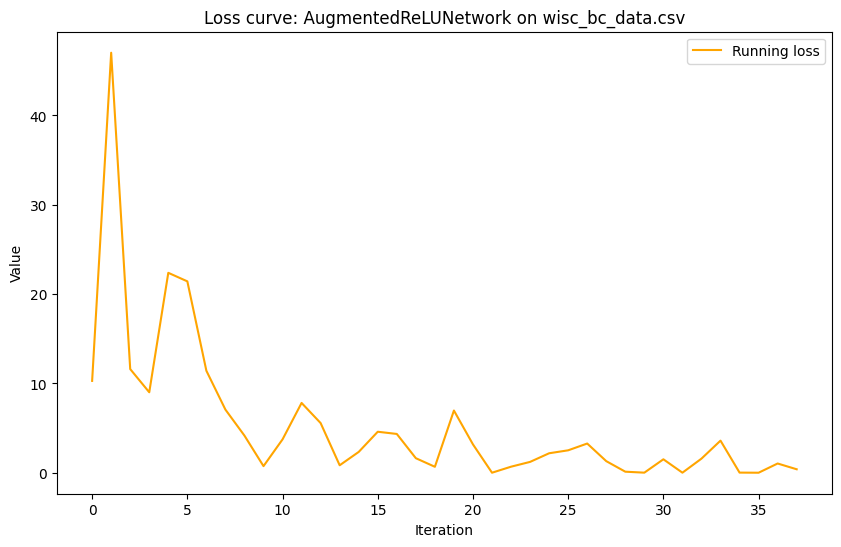

E1/1 S1/116 Loss=0.0131
E1/1 S2/116 Loss=0.0121
E1/1 S3/116 Loss=0.0120
E1/1 S4/116 Loss=0.0093
E1/1 S5/116 Loss=0.0064
E1/1 S6/116 Loss=0.0105
E1/1 S7/116 Loss=0.0078
E1/1 S8/116 Loss=0.0103
E1/1 S9/116 Loss=0.0138
E1/1 S10/116 Loss=0.0068
E1/1 S11/116 Loss=0.0076
E1/1 S12/116 Loss=0.0067
E1/1 S13/116 Loss=0.0076
E1/1 S14/116 Loss=0.0029
E1/1 S15/116 Loss=0.0093
E1/1 S16/116 Loss=0.0072
E1/1 S17/116 Loss=0.0114
E1/1 S18/116 Loss=0.0095
E1/1 S19/116 Loss=0.0071
E1/1 S20/116 Loss=0.0064
E1/1 S21/116 Loss=0.0074
E1/1 S22/116 Loss=0.0062
E1/1 S23/116 Loss=0.0068
E1/1 S24/116 Loss=0.0084
E1/1 S25/116 Loss=0.0128
E1/1 S26/116 Loss=0.0116
E1/1 S27/116 Loss=0.0050
E1/1 S28/116 Loss=0.0052
E1/1 S29/116 Loss=0.0053
E1/1 S30/116 Loss=0.0069
E1/1 S31/116 Loss=0.0096
E1/1 S32/116 Loss=0.0065
E1/1 S33/116 Loss=0.0066
E1/1 S34/116 Loss=0.0090
E1/1 S35/116 Loss=0.0061
E1/1 S36/116 Loss=0.0110
E1/1 S37/116 Loss=0.0068
E1/1 S38/116 Loss=0.0071
E1/1 S39/116 Loss=0.0067
E1/1 S40/116 Loss=0.0067
E1/1 S41/

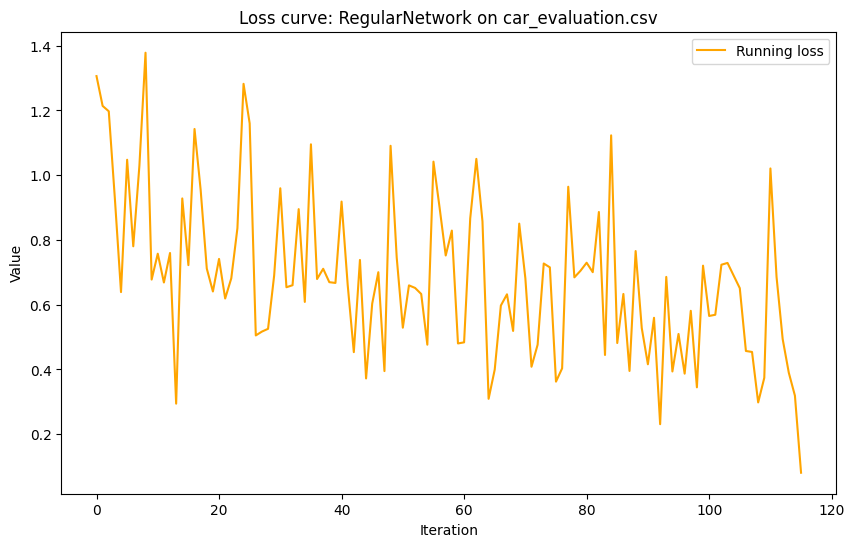

E1/1 S1/116 Loss=0.0132
E1/1 S2/116 Loss=0.0114
E1/1 S3/116 Loss=0.0113
E1/1 S4/116 Loss=0.0115
E1/1 S5/116 Loss=0.0080
E1/1 S6/116 Loss=0.0126
E1/1 S7/116 Loss=0.0112
E1/1 S8/116 Loss=0.0089
E1/1 S9/116 Loss=0.0114
E1/1 S10/116 Loss=0.0080
E1/1 S11/116 Loss=0.0056
E1/1 S12/116 Loss=0.0064
E1/1 S13/116 Loss=0.0117
E1/1 S14/116 Loss=0.0105
E1/1 S15/116 Loss=0.0093
E1/1 S16/116 Loss=0.0104
E1/1 S17/116 Loss=0.0085
E1/1 S18/116 Loss=0.0072
E1/1 S19/116 Loss=0.0058
E1/1 S20/116 Loss=0.0063
E1/1 S21/116 Loss=0.0076
E1/1 S22/116 Loss=0.0096
E1/1 S23/116 Loss=0.0067
E1/1 S24/116 Loss=0.0049
E1/1 S25/116 Loss=0.0092
E1/1 S26/116 Loss=0.0051
E1/1 S27/116 Loss=0.0055
E1/1 S28/116 Loss=0.0084
E1/1 S29/116 Loss=0.0098
E1/1 S30/116 Loss=0.0062
E1/1 S31/116 Loss=0.0091
E1/1 S32/116 Loss=0.0092
E1/1 S33/116 Loss=0.0080
E1/1 S34/116 Loss=0.0043
E1/1 S35/116 Loss=0.0048
E1/1 S36/116 Loss=0.0062
E1/1 S37/116 Loss=0.0111
E1/1 S38/116 Loss=0.0044
E1/1 S39/116 Loss=0.0073
E1/1 S40/116 Loss=0.0043
E1/1 S41/

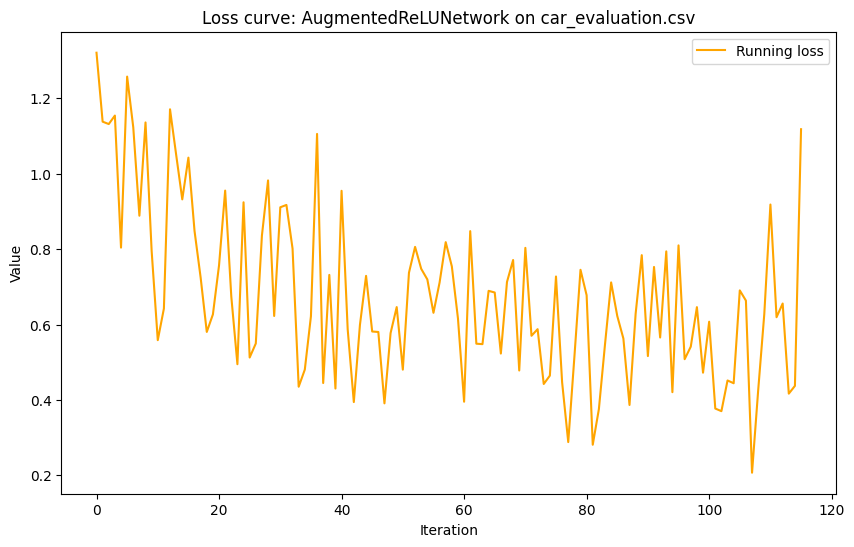

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E1/1 S1/436 Loss=40.0155
E1/1 S2/436 Loss=32.1941
E1/1 S3/436 Loss=27.6431
E1/1 S4/436 Loss=23.3618
E1/1 S5/436 Loss=18.2170
E1/1 S6/436 Loss=15.1959
E1/1 S7/436 Loss=12.3349
E1/1 S8/436 Loss=9.1798
E1/1 S9/436 Loss=6.7165
E1/1 S10/436 Loss=3.6238
E1/1 S11/436 Loss=3.7863
E1/1 S12/436 Loss=1.2929
E1/1 S13/436 Loss=1.6874
E1/1 S14/436 Loss=0.7926
E1/1 S15/436 Loss=0.6717
E1/1 S16/436 Loss=0.7137
E1/1 S17/436 Loss=0.9343
E1/1 S18/436 Loss=0.7851
E1/1 S19/436 Loss=1.0309
E1/1 S20/436 Loss=1.6573
E1/1 S21/436 Loss=1.0492
E1/1 S22/436 Loss=1.2114
E1/1 S23/436 Loss=2.4265
E1/1 S24/436 Loss=1.7007
E1/1 S25/436 Loss=1.7043
E1/1 S26/436 Loss=2.2813
E1/1 S27/436 Loss=1.2491
E1/1 S28/436 Loss=1.3870
E1/1 S29/436 Loss=2.6551
E1/1 S30/436 Loss=1.3835
E1/1 S31/436 Loss=0.7101
E1/1 S32/436 Loss=0.5703
E1/1 S33/436 Loss=0.8709
E1/1 S34/436 Loss=0.6723
E1/1 S35/436 Loss=0.6817
E1/1 S36/436 Loss=0.6017
E1/1 S37/436 Loss=0.5909
E1/1 S38/436 Loss=0.8766
E1/1 S39/436 Loss=0.7211
E1/1 S40/436 Loss=0.6366
E1

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


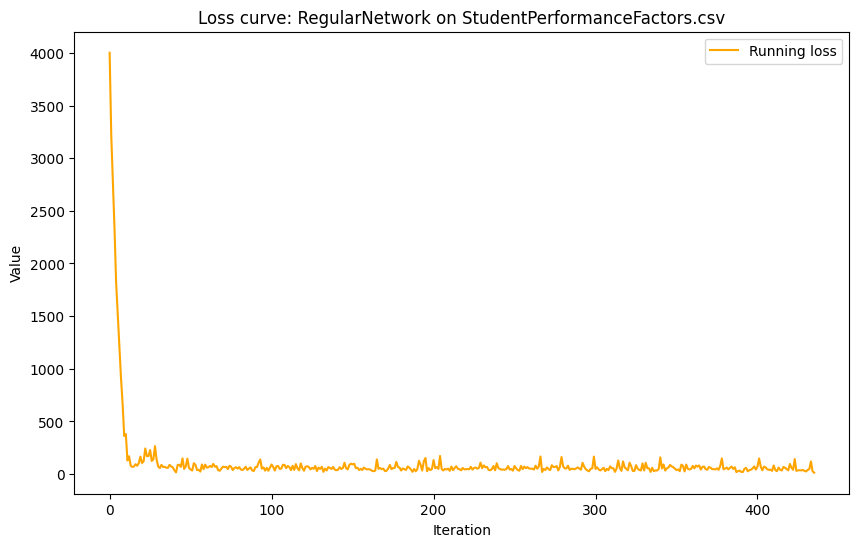

E1/1 S1/436 Loss=43.3193
E1/1 S2/436 Loss=33.6821
E1/1 S3/436 Loss=31.0035
E1/1 S4/436 Loss=25.1423
E1/1 S5/436 Loss=20.5511
E1/1 S6/436 Loss=16.1991
E1/1 S7/436 Loss=14.2764
E1/1 S8/436 Loss=11.6378
E1/1 S9/436 Loss=9.0916
E1/1 S10/436 Loss=7.3241
E1/1 S11/436 Loss=5.7453
E1/1 S12/436 Loss=4.0154
E1/1 S13/436 Loss=2.2226
E1/1 S14/436 Loss=1.9317
E1/1 S15/436 Loss=1.0245
E1/1 S16/436 Loss=1.6584
E1/1 S17/436 Loss=1.2321
E1/1 S18/436 Loss=0.7536
E1/1 S19/436 Loss=0.7077
E1/1 S20/436 Loss=0.6501
E1/1 S21/436 Loss=1.5675
E1/1 S22/436 Loss=1.2273
E1/1 S23/436 Loss=1.6620
E1/1 S24/436 Loss=0.9294
E1/1 S25/436 Loss=1.4266
E1/1 S26/436 Loss=1.9052
E1/1 S27/436 Loss=2.2531
E1/1 S28/436 Loss=3.5981
E1/1 S29/436 Loss=1.7406
E1/1 S30/436 Loss=1.6373
E1/1 S31/436 Loss=2.9613
E1/1 S32/436 Loss=2.2524
E1/1 S33/436 Loss=1.2784
E1/1 S34/436 Loss=1.0283
E1/1 S35/436 Loss=0.9428
E1/1 S36/436 Loss=0.6057
E1/1 S37/436 Loss=0.8785
E1/1 S38/436 Loss=0.9606
E1/1 S39/436 Loss=0.5961
E1/1 S40/436 Loss=0.6910
E

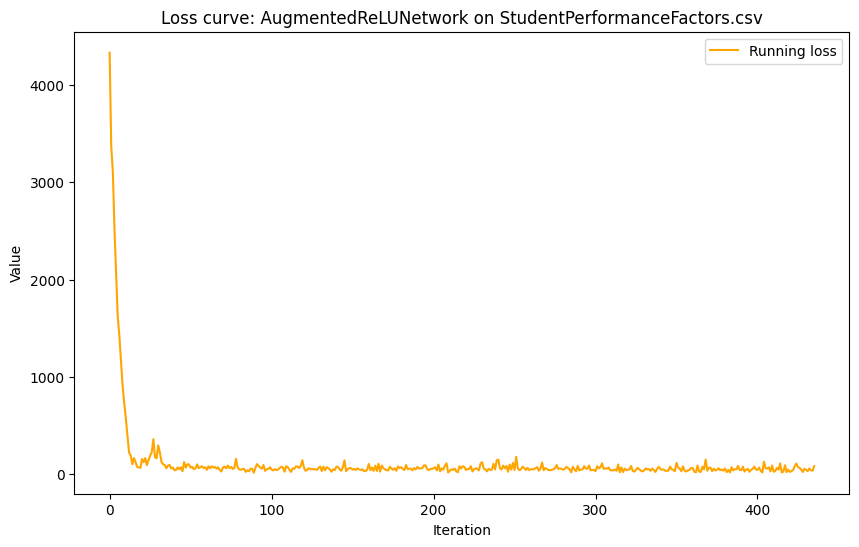

E1/1 S1/38 Loss=0.2835
E1/1 S2/38 Loss=0.1531
E1/1 S3/38 Loss=0.1014
E1/1 S4/38 Loss=0.2602
E1/1 S5/38 Loss=0.3455
E1/1 S6/38 Loss=0.3569
E1/1 S7/38 Loss=0.1637
E1/1 S8/38 Loss=0.0611
E1/1 S9/38 Loss=0.0549
E1/1 S10/38 Loss=0.0578
E1/1 S11/38 Loss=0.1264
E1/1 S12/38 Loss=0.0729
E1/1 S13/38 Loss=0.0818
E1/1 S14/38 Loss=0.0001
E1/1 S15/38 Loss=0.0644
E1/1 S16/38 Loss=0.0568
E1/1 S17/38 Loss=0.0488
E1/1 S18/38 Loss=0.0314
E1/1 S19/38 Loss=0.0114
E1/1 S20/38 Loss=0.0112
E1/1 S21/38 Loss=0.0384
E1/1 S22/38 Loss=0.0082
E1/1 S23/38 Loss=0.0205
E1/1 S24/38 Loss=0.0524
E1/1 S25/38 Loss=0.0259
E1/1 S26/38 Loss=0.0173
E1/1 S27/38 Loss=0.0080
E1/1 S28/38 Loss=0.0236
E1/1 S29/38 Loss=0.0716
E1/1 S30/38 Loss=0.0049
E1/1 S31/38 Loss=0.0084
E1/1 S32/38 Loss=0.0057
E1/1 S33/38 Loss=0.0149
E1/1 S34/38 Loss=0.0267
E1/1 S35/38 Loss=0.0289
E1/1 S36/38 Loss=0.0003
E1/1 S37/38 Loss=0.0001
E1/1 S38/38 Loss=0.0000


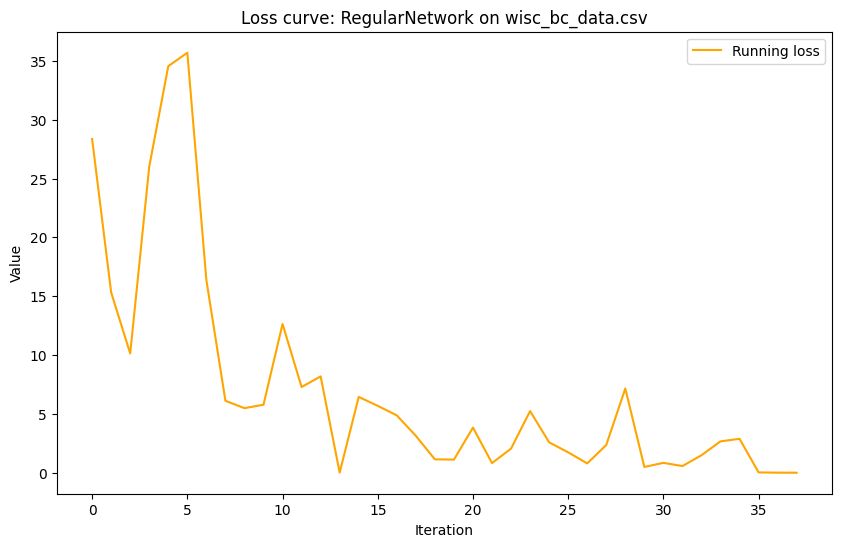

E1/1 S1/38 Loss=0.0821
E1/1 S2/38 Loss=0.3677
E1/1 S3/38 Loss=0.3713
E1/1 S4/38 Loss=0.0689
E1/1 S5/38 Loss=0.1205
E1/1 S6/38 Loss=0.2458
E1/1 S7/38 Loss=0.2213
E1/1 S8/38 Loss=0.4063
E1/1 S9/38 Loss=0.2537
E1/1 S10/38 Loss=0.2625
E1/1 S11/38 Loss=0.0957
E1/1 S12/38 Loss=0.0033
E1/1 S13/38 Loss=0.1366
E1/1 S14/38 Loss=0.1957
E1/1 S15/38 Loss=0.2938
E1/1 S16/38 Loss=0.1674
E1/1 S17/38 Loss=0.1449
E1/1 S18/38 Loss=0.0001
E1/1 S19/38 Loss=0.0880
E1/1 S20/38 Loss=0.1275
E1/1 S21/38 Loss=0.1960
E1/1 S22/38 Loss=0.2562
E1/1 S23/38 Loss=0.2163
E1/1 S24/38 Loss=0.2615
E1/1 S25/38 Loss=0.0825
E1/1 S26/38 Loss=0.0384
E1/1 S27/38 Loss=0.0107
E1/1 S28/38 Loss=0.0107
E1/1 S29/38 Loss=0.0394
E1/1 S30/38 Loss=0.0775
E1/1 S31/38 Loss=0.1070
E1/1 S32/38 Loss=0.1081
E1/1 S33/38 Loss=0.0909
E1/1 S34/38 Loss=0.0005
E1/1 S35/38 Loss=0.0013
E1/1 S36/38 Loss=0.0258
E1/1 S37/38 Loss=0.0449
E1/1 S38/38 Loss=0.0641


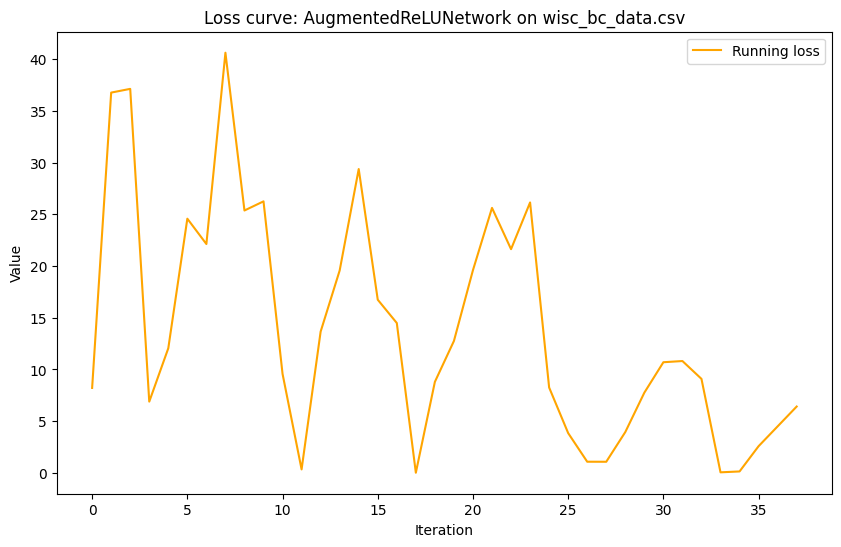

E1/1 S1/116 Loss=0.0138
E1/1 S2/116 Loss=0.0122
E1/1 S3/116 Loss=0.0122
E1/1 S4/116 Loss=0.0114
E1/1 S5/116 Loss=0.0075
E1/1 S6/116 Loss=0.0114
E1/1 S7/116 Loss=0.0077
E1/1 S8/116 Loss=0.0088
E1/1 S9/116 Loss=0.0097
E1/1 S10/116 Loss=0.0093
E1/1 S11/116 Loss=0.0063
E1/1 S12/116 Loss=0.0092
E1/1 S13/116 Loss=0.0094
E1/1 S14/116 Loss=0.0073
E1/1 S15/116 Loss=0.0100
E1/1 S16/116 Loss=0.0083
E1/1 S17/116 Loss=0.0064
E1/1 S18/116 Loss=0.0079
E1/1 S19/116 Loss=0.0112
E1/1 S20/116 Loss=0.0095
E1/1 S21/116 Loss=0.0058
E1/1 S22/116 Loss=0.0042
E1/1 S23/116 Loss=0.0082
E1/1 S24/116 Loss=0.0081
E1/1 S25/116 Loss=0.0131
E1/1 S26/116 Loss=0.0041
E1/1 S27/116 Loss=0.0058
E1/1 S28/116 Loss=0.0128
E1/1 S29/116 Loss=0.0053
E1/1 S30/116 Loss=0.0083
E1/1 S31/116 Loss=0.0087
E1/1 S32/116 Loss=0.0093
E1/1 S33/116 Loss=0.0053
E1/1 S34/116 Loss=0.0088
E1/1 S35/116 Loss=0.0085
E1/1 S36/116 Loss=0.0093
E1/1 S37/116 Loss=0.0052
E1/1 S38/116 Loss=0.0076
E1/1 S39/116 Loss=0.0080
E1/1 S40/116 Loss=0.0065
E1/1 S41/

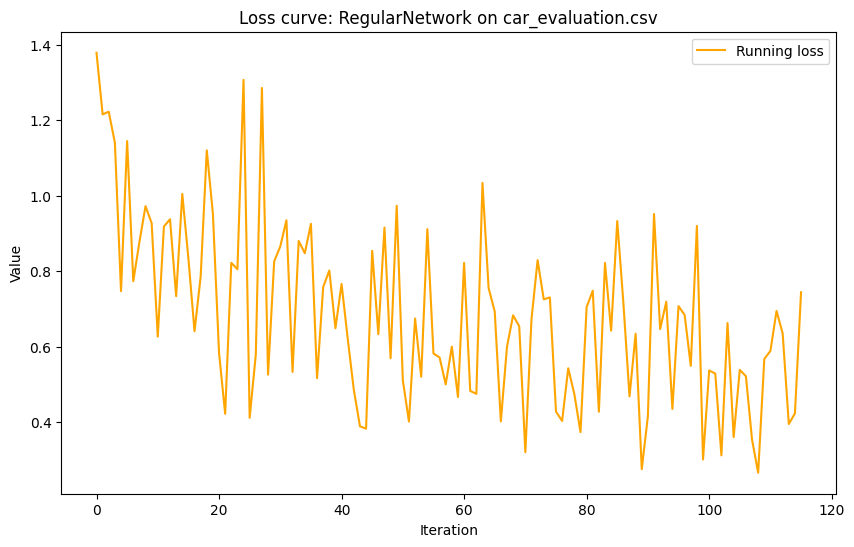

E1/1 S1/116 Loss=0.0134
E1/1 S2/116 Loss=0.0125
E1/1 S3/116 Loss=0.0103
E1/1 S4/116 Loss=0.0103
E1/1 S5/116 Loss=0.0083
E1/1 S6/116 Loss=0.0110
E1/1 S7/116 Loss=0.0139
E1/1 S8/116 Loss=0.0117
E1/1 S9/116 Loss=0.0068
E1/1 S10/116 Loss=0.0077
E1/1 S11/116 Loss=0.0111
E1/1 S12/116 Loss=0.0040
E1/1 S13/116 Loss=0.0082
E1/1 S14/116 Loss=0.0115
E1/1 S15/116 Loss=0.0138
E1/1 S16/116 Loss=0.0050
E1/1 S17/116 Loss=0.0101
E1/1 S18/116 Loss=0.0095
E1/1 S19/116 Loss=0.0102
E1/1 S20/116 Loss=0.0101
E1/1 S21/116 Loss=0.0068
E1/1 S22/116 Loss=0.0064
E1/1 S23/116 Loss=0.0127
E1/1 S24/116 Loss=0.0062
E1/1 S25/116 Loss=0.0098
E1/1 S26/116 Loss=0.0087
E1/1 S27/116 Loss=0.0036
E1/1 S28/116 Loss=0.0082
E1/1 S29/116 Loss=0.0060
E1/1 S30/116 Loss=0.0056
E1/1 S31/116 Loss=0.0109
E1/1 S32/116 Loss=0.0085
E1/1 S33/116 Loss=0.0054
E1/1 S34/116 Loss=0.0062
E1/1 S35/116 Loss=0.0085
E1/1 S36/116 Loss=0.0049
E1/1 S37/116 Loss=0.0063
E1/1 S38/116 Loss=0.0073
E1/1 S39/116 Loss=0.0044
E1/1 S40/116 Loss=0.0057
E1/1 S41/

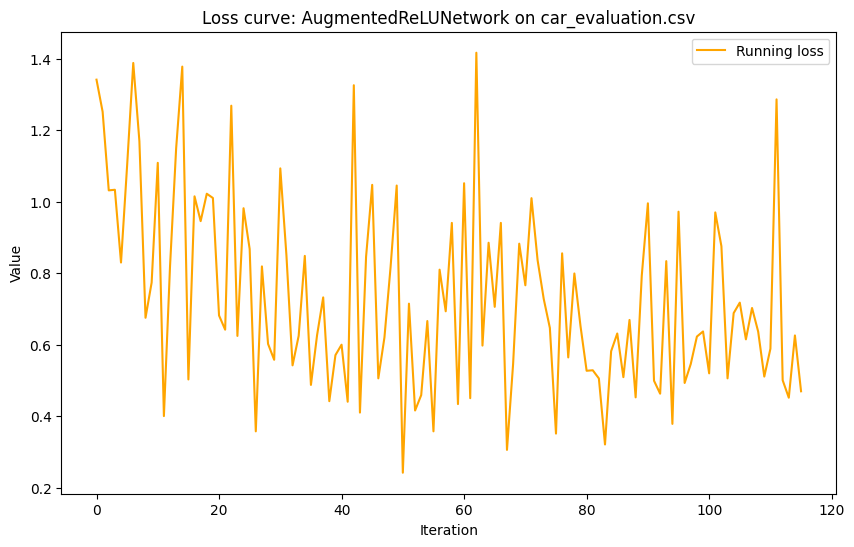

E1/1 S1/436 Loss=40.6115
E1/1 S2/436 Loss=34.3517
E1/1 S3/436 Loss=28.4333
E1/1 S4/436 Loss=24.5714
E1/1 S5/436 Loss=18.8915
E1/1 S6/436 Loss=16.4675
E1/1 S7/436 Loss=12.1857
E1/1 S8/436 Loss=9.5563
E1/1 S9/436 Loss=7.0402
E1/1 S10/436 Loss=3.9050
E1/1 S11/436 Loss=3.5180
E1/1 S12/436 Loss=2.3069
E1/1 S13/436 Loss=1.0354
E1/1 S14/436 Loss=0.6220
E1/1 S15/436 Loss=0.6695
E1/1 S16/436 Loss=0.3962
E1/1 S17/436 Loss=0.2973
E1/1 S18/436 Loss=1.3183
E1/1 S19/436 Loss=1.3424
E1/1 S20/436 Loss=0.9206
E1/1 S21/436 Loss=1.2484
E1/1 S22/436 Loss=1.6660
E1/1 S23/436 Loss=1.8087
E1/1 S24/436 Loss=2.2135
E1/1 S25/436 Loss=3.5453
E1/1 S26/436 Loss=2.8033
E1/1 S27/436 Loss=1.9618
E1/1 S28/436 Loss=1.7946
E1/1 S29/436 Loss=1.0563
E1/1 S30/436 Loss=0.9910
E1/1 S31/436 Loss=1.5177
E1/1 S32/436 Loss=1.4581
E1/1 S33/436 Loss=0.9344
E1/1 S34/436 Loss=1.2635
E1/1 S35/436 Loss=0.9100
E1/1 S36/436 Loss=0.5649
E1/1 S37/436 Loss=0.5591
E1/1 S38/436 Loss=0.5303
E1/1 S39/436 Loss=0.8098
E1/1 S40/436 Loss=0.6240
E1

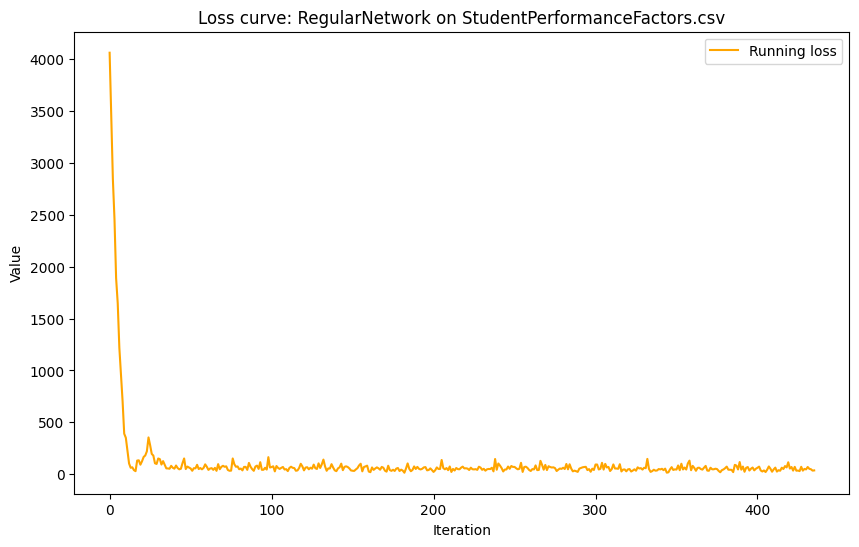

E1/1 S1/436 Loss=40.0416
E1/1 S2/436 Loss=35.7832
E1/1 S3/436 Loss=28.0328
E1/1 S4/436 Loss=22.7017
E1/1 S5/436 Loss=18.2395
E1/1 S6/436 Loss=14.3092
E1/1 S7/436 Loss=10.4227
E1/1 S8/436 Loss=8.7539
E1/1 S9/436 Loss=6.0597
E1/1 S10/436 Loss=5.0380
E1/1 S11/436 Loss=3.5259
E1/1 S12/436 Loss=2.5360
E1/1 S13/436 Loss=1.6937
E1/1 S14/436 Loss=1.1701
E1/1 S15/436 Loss=0.5036
E1/1 S16/436 Loss=0.3476
E1/1 S17/436 Loss=0.7565
E1/1 S18/436 Loss=1.0382
E1/1 S19/436 Loss=1.1054
E1/1 S20/436 Loss=0.9012
E1/1 S21/436 Loss=1.5541
E1/1 S22/436 Loss=1.4502
E1/1 S23/436 Loss=1.7867
E1/1 S24/436 Loss=1.4117
E1/1 S25/436 Loss=2.3902
E1/1 S26/436 Loss=3.0024
E1/1 S27/436 Loss=1.7629
E1/1 S28/436 Loss=1.5420
E1/1 S29/436 Loss=3.1196
E1/1 S30/436 Loss=1.2135
E1/1 S31/436 Loss=1.9833
E1/1 S32/436 Loss=1.3995
E1/1 S33/436 Loss=1.1136
E1/1 S34/436 Loss=1.2649
E1/1 S35/436 Loss=0.9582
E1/1 S36/436 Loss=0.4748
E1/1 S37/436 Loss=0.6931
E1/1 S38/436 Loss=0.3683
E1/1 S39/436 Loss=0.6257
E1/1 S40/436 Loss=0.5406
E1

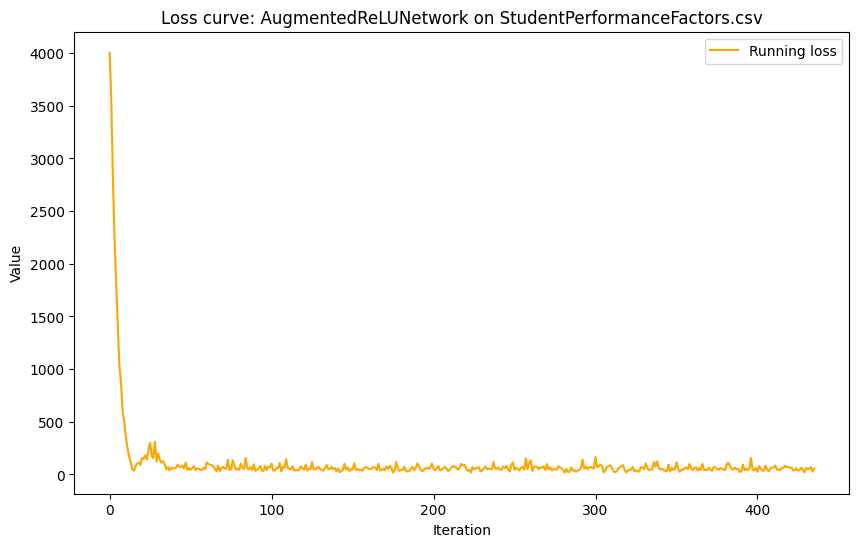

E1/1 S1/38 Loss=0.1672
E1/1 S2/38 Loss=0.0555
E1/1 S3/38 Loss=0.0740
E1/1 S4/38 Loss=0.0776
E1/1 S5/38 Loss=0.0043
E1/1 S6/38 Loss=0.0461
E1/1 S7/38 Loss=0.0007
E1/1 S8/38 Loss=0.0084
E1/1 S9/38 Loss=0.0083
E1/1 S10/38 Loss=0.0050
E1/1 S11/38 Loss=0.0109
E1/1 S12/38 Loss=0.0072
E1/1 S13/38 Loss=0.0001
E1/1 S14/38 Loss=0.0059
E1/1 S15/38 Loss=0.0030
E1/1 S16/38 Loss=0.0051
E1/1 S17/38 Loss=0.0003
E1/1 S18/38 Loss=0.0069
E1/1 S19/38 Loss=0.0005
E1/1 S20/38 Loss=0.0117
E1/1 S21/38 Loss=0.0096
E1/1 S22/38 Loss=0.0079
E1/1 S23/38 Loss=0.0204
E1/1 S24/38 Loss=0.0153
E1/1 S25/38 Loss=0.0070
E1/1 S26/38 Loss=0.0100
E1/1 S27/38 Loss=0.0119
E1/1 S28/38 Loss=0.0811
E1/1 S29/38 Loss=0.0039
E1/1 S30/38 Loss=0.0130
E1/1 S31/38 Loss=0.0335
E1/1 S32/38 Loss=0.0434
E1/1 S33/38 Loss=0.0257
E1/1 S34/38 Loss=0.0124
E1/1 S35/38 Loss=0.0482
E1/1 S36/38 Loss=0.0226
E1/1 S37/38 Loss=0.0053
E1/1 S38/38 Loss=0.0119


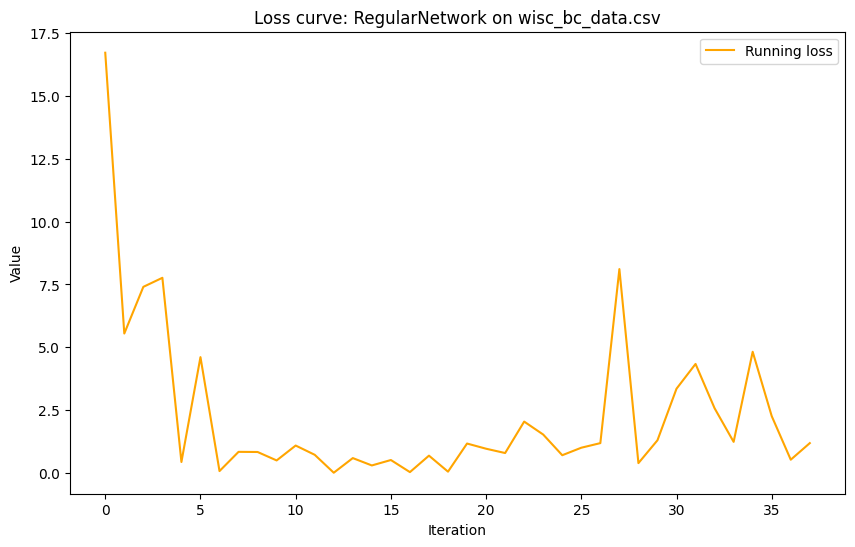

E1/1 S1/38 Loss=0.0814
E1/1 S2/38 Loss=0.1572
E1/1 S3/38 Loss=0.1793
E1/1 S4/38 Loss=0.0019
E1/1 S5/38 Loss=0.2096
E1/1 S6/38 Loss=0.0779
E1/1 S7/38 Loss=0.0170
E1/1 S8/38 Loss=0.0084
E1/1 S9/38 Loss=0.0679
E1/1 S10/38 Loss=0.0184
E1/1 S11/38 Loss=0.0015
E1/1 S12/38 Loss=0.0400
E1/1 S13/38 Loss=0.0187
E1/1 S14/38 Loss=0.0022
E1/1 S15/38 Loss=0.0001
E1/1 S16/38 Loss=0.0158
E1/1 S17/38 Loss=0.0132
E1/1 S18/38 Loss=0.0026
E1/1 S19/38 Loss=0.0102
E1/1 S20/38 Loss=0.0082
E1/1 S21/38 Loss=0.0127
E1/1 S22/38 Loss=0.0078
E1/1 S23/38 Loss=0.0116
E1/1 S24/38 Loss=0.0001
E1/1 S25/38 Loss=0.0006
E1/1 S26/38 Loss=0.0050
E1/1 S27/38 Loss=0.0107
E1/1 S28/38 Loss=0.0009
E1/1 S29/38 Loss=0.0000
E1/1 S30/38 Loss=0.0117
E1/1 S31/38 Loss=0.0013
E1/1 S32/38 Loss=0.0006
E1/1 S33/38 Loss=0.0033
E1/1 S34/38 Loss=0.0081
E1/1 S35/38 Loss=0.0006
E1/1 S36/38 Loss=0.0000
E1/1 S37/38 Loss=0.0107
E1/1 S38/38 Loss=0.0132


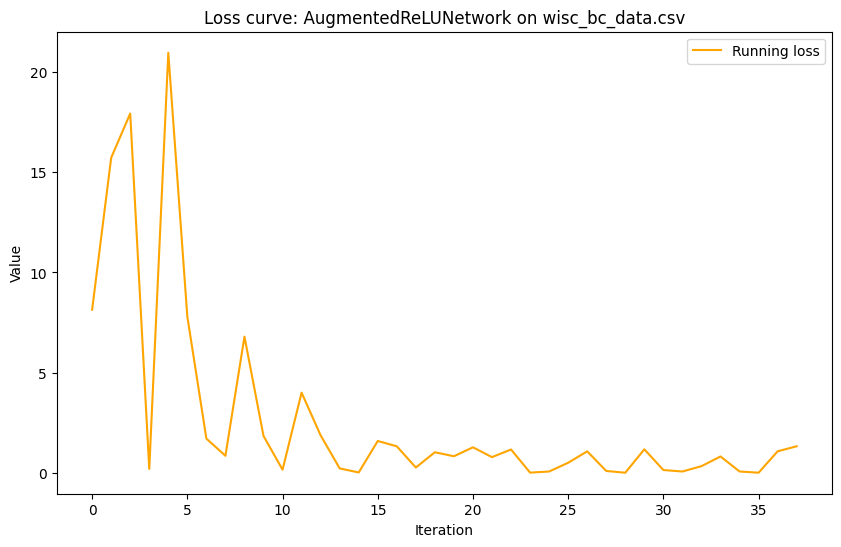

E1/1 S1/116 Loss=0.0150
E1/1 S2/116 Loss=0.0130
E1/1 S3/116 Loss=0.0117
E1/1 S4/116 Loss=0.0103
E1/1 S5/116 Loss=0.0088
E1/1 S6/116 Loss=0.0107
E1/1 S7/116 Loss=0.0097
E1/1 S8/116 Loss=0.0059
E1/1 S9/116 Loss=0.0081
E1/1 S10/116 Loss=0.0088
E1/1 S11/116 Loss=0.0122
E1/1 S12/116 Loss=0.0093
E1/1 S13/116 Loss=0.0087
E1/1 S14/116 Loss=0.0135
E1/1 S15/116 Loss=0.0041
E1/1 S16/116 Loss=0.0086
E1/1 S17/116 Loss=0.0069
E1/1 S18/116 Loss=0.0101
E1/1 S19/116 Loss=0.0055
E1/1 S20/116 Loss=0.0050
E1/1 S21/116 Loss=0.0166
E1/1 S22/116 Loss=0.0104
E1/1 S23/116 Loss=0.0058
E1/1 S24/116 Loss=0.0053
E1/1 S25/116 Loss=0.0051
E1/1 S26/116 Loss=0.0137
E1/1 S27/116 Loss=0.0117
E1/1 S28/116 Loss=0.0134
E1/1 S29/116 Loss=0.0057
E1/1 S30/116 Loss=0.0130
E1/1 S31/116 Loss=0.0048
E1/1 S32/116 Loss=0.0086
E1/1 S33/116 Loss=0.0053
E1/1 S34/116 Loss=0.0051
E1/1 S35/116 Loss=0.0074
E1/1 S36/116 Loss=0.0110
E1/1 S37/116 Loss=0.0052
E1/1 S38/116 Loss=0.0112
E1/1 S39/116 Loss=0.0123
E1/1 S40/116 Loss=0.0070
E1/1 S41/

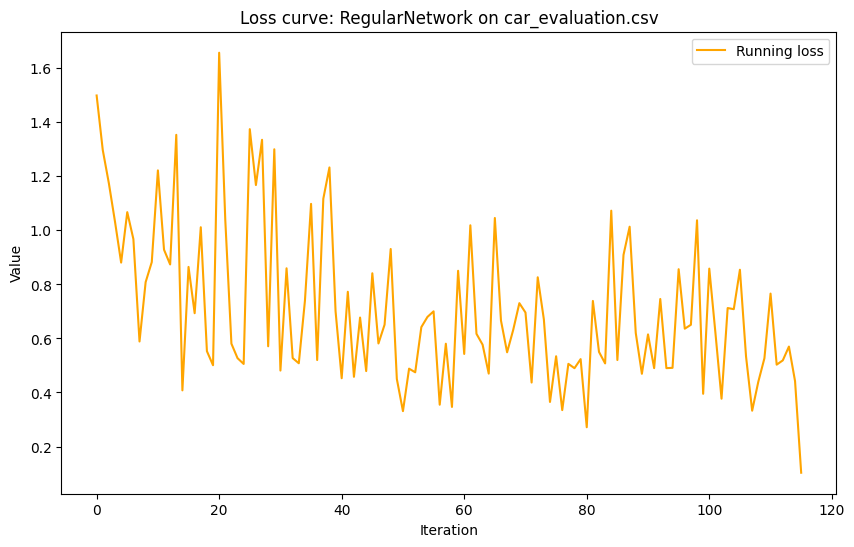

E1/1 S1/116 Loss=0.0139
E1/1 S2/116 Loss=0.0142
E1/1 S3/116 Loss=0.0123
E1/1 S4/116 Loss=0.0116
E1/1 S5/116 Loss=0.0108
E1/1 S6/116 Loss=0.0083
E1/1 S7/116 Loss=0.0132
E1/1 S8/116 Loss=0.0087
E1/1 S9/116 Loss=0.0075
E1/1 S10/116 Loss=0.0089
E1/1 S11/116 Loss=0.0063
E1/1 S12/116 Loss=0.0079
E1/1 S13/116 Loss=0.0057
E1/1 S14/116 Loss=0.0077
E1/1 S15/116 Loss=0.0107
E1/1 S16/116 Loss=0.0061
E1/1 S17/116 Loss=0.0081
E1/1 S18/116 Loss=0.0100
E1/1 S19/116 Loss=0.0082
E1/1 S20/116 Loss=0.0064
E1/1 S21/116 Loss=0.0115
E1/1 S22/116 Loss=0.0135
E1/1 S23/116 Loss=0.0107
E1/1 S24/116 Loss=0.0095
E1/1 S25/116 Loss=0.0041
E1/1 S26/116 Loss=0.0112
E1/1 S27/116 Loss=0.0107
E1/1 S28/116 Loss=0.0087
E1/1 S29/116 Loss=0.0070
E1/1 S30/116 Loss=0.0095
E1/1 S31/116 Loss=0.0057
E1/1 S32/116 Loss=0.0063
E1/1 S33/116 Loss=0.0083
E1/1 S34/116 Loss=0.0074
E1/1 S35/116 Loss=0.0093
E1/1 S36/116 Loss=0.0074
E1/1 S37/116 Loss=0.0093
E1/1 S38/116 Loss=0.0080
E1/1 S39/116 Loss=0.0092
E1/1 S40/116 Loss=0.0038
E1/1 S41/

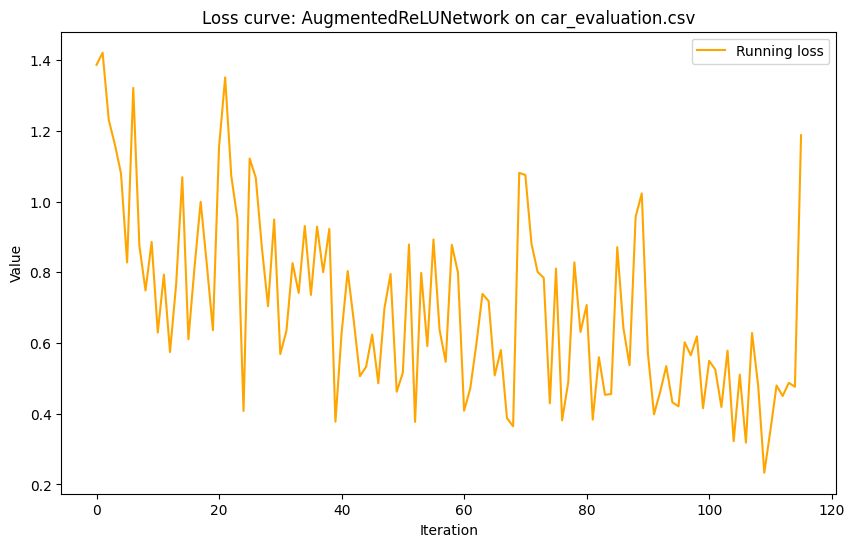

E1/1 S1/436 Loss=47.3209
E1/1 S2/436 Loss=40.4229
E1/1 S3/436 Loss=34.9977
E1/1 S4/436 Loss=31.1549
E1/1 S5/436 Loss=26.1598
E1/1 S6/436 Loss=21.8208
E1/1 S7/436 Loss=18.8975
E1/1 S8/436 Loss=13.3581
E1/1 S9/436 Loss=10.4713
E1/1 S10/436 Loss=7.8893
E1/1 S11/436 Loss=7.4797
E1/1 S12/436 Loss=4.8770
E1/1 S13/436 Loss=4.3644
E1/1 S14/436 Loss=2.6766
E1/1 S15/436 Loss=2.1575
E1/1 S16/436 Loss=1.8422
E1/1 S17/436 Loss=1.2393
E1/1 S18/436 Loss=0.8962
E1/1 S19/436 Loss=0.5169
E1/1 S20/436 Loss=0.5049
E1/1 S21/436 Loss=0.6796
E1/1 S22/436 Loss=0.9723
E1/1 S23/436 Loss=0.7438
E1/1 S24/436 Loss=1.4402
E1/1 S25/436 Loss=1.0125
E1/1 S26/436 Loss=2.4029
E1/1 S27/436 Loss=2.4345
E1/1 S28/436 Loss=1.8984
E1/1 S29/436 Loss=1.5327
E1/1 S30/436 Loss=1.4221
E1/1 S31/436 Loss=1.7879
E1/1 S32/436 Loss=2.1292
E1/1 S33/436 Loss=2.0126
E1/1 S34/436 Loss=1.3366
E1/1 S35/436 Loss=1.3992
E1/1 S36/436 Loss=1.0138
E1/1 S37/436 Loss=1.2662
E1/1 S38/436 Loss=1.9334
E1/1 S39/436 Loss=0.8048
E1/1 S40/436 Loss=0.8229


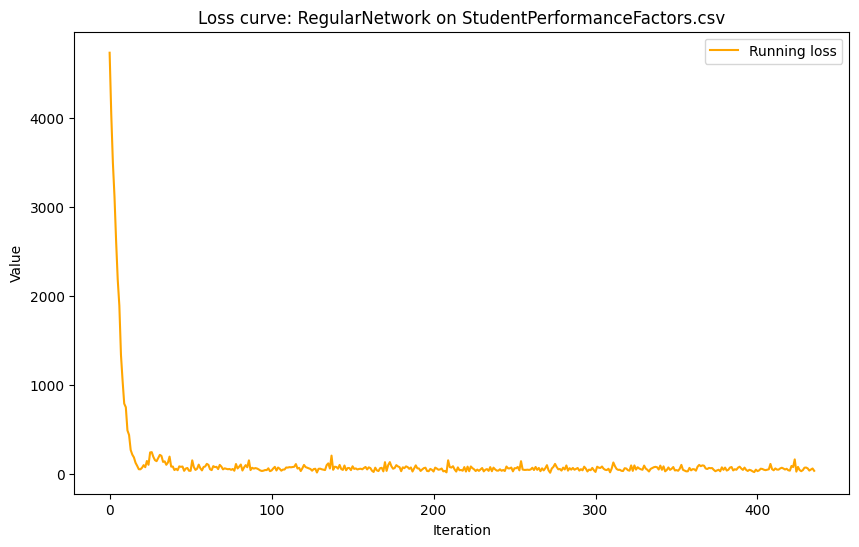

E1/1 S1/436 Loss=49.2128
E1/1 S2/436 Loss=44.5610
E1/1 S3/436 Loss=37.0637
E1/1 S4/436 Loss=30.9212
E1/1 S5/436 Loss=25.7854
E1/1 S6/436 Loss=20.9526
E1/1 S7/436 Loss=18.9767
E1/1 S8/436 Loss=14.7150
E1/1 S9/436 Loss=12.0346
E1/1 S10/436 Loss=8.8667
E1/1 S11/436 Loss=6.5450
E1/1 S12/436 Loss=4.7441
E1/1 S13/436 Loss=3.9556
E1/1 S14/436 Loss=3.7138
E1/1 S15/436 Loss=2.5187
E1/1 S16/436 Loss=1.2290
E1/1 S17/436 Loss=0.5727
E1/1 S18/436 Loss=0.8383
E1/1 S19/436 Loss=0.6181
E1/1 S20/436 Loss=0.7281
E1/1 S21/436 Loss=0.8069
E1/1 S22/436 Loss=2.2578
E1/1 S23/436 Loss=1.6111
E1/1 S24/436 Loss=0.6968
E1/1 S25/436 Loss=1.8496
E1/1 S26/436 Loss=2.9114
E1/1 S27/436 Loss=2.1743
E1/1 S28/436 Loss=2.0633
E1/1 S29/436 Loss=1.7772
E1/1 S30/436 Loss=1.7154
E1/1 S31/436 Loss=1.8418
E1/1 S32/436 Loss=2.0988
E1/1 S33/436 Loss=1.2052
E1/1 S34/436 Loss=0.8975
E1/1 S35/436 Loss=0.7661
E1/1 S36/436 Loss=0.9522
E1/1 S37/436 Loss=0.8161
E1/1 S38/436 Loss=0.3630
E1/1 S39/436 Loss=0.8915
E1/1 S40/436 Loss=0.6806


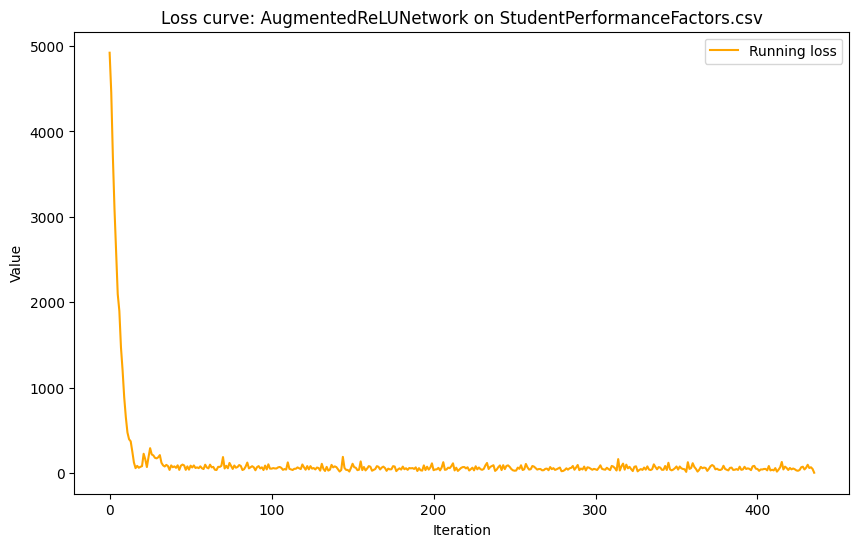

E1/1 S1/38 Loss=0.1464
E1/1 S2/38 Loss=0.1168
E1/1 S3/38 Loss=0.0305
E1/1 S4/38 Loss=0.0675
E1/1 S5/38 Loss=0.1233
E1/1 S6/38 Loss=0.0877
E1/1 S7/38 Loss=0.0148
E1/1 S8/38 Loss=0.0689
E1/1 S9/38 Loss=0.2166
E1/1 S10/38 Loss=0.0079
E1/1 S11/38 Loss=0.0002
E1/1 S12/38 Loss=0.0068
E1/1 S13/38 Loss=0.0628
E1/1 S14/38 Loss=0.0446
E1/1 S15/38 Loss=0.0460
E1/1 S16/38 Loss=0.0004
E1/1 S17/38 Loss=0.0763
E1/1 S18/38 Loss=0.0291
E1/1 S19/38 Loss=0.0498
E1/1 S20/38 Loss=0.0558
E1/1 S21/38 Loss=0.0000
E1/1 S22/38 Loss=0.0083
E1/1 S23/38 Loss=0.0063
E1/1 S24/38 Loss=0.0425
E1/1 S25/38 Loss=0.0335
E1/1 S26/38 Loss=0.0330
E1/1 S27/38 Loss=0.0264
E1/1 S28/38 Loss=0.0193
E1/1 S29/38 Loss=0.0306
E1/1 S30/38 Loss=0.0041
E1/1 S31/38 Loss=0.0258
E1/1 S32/38 Loss=0.0359
E1/1 S33/38 Loss=0.0132
E1/1 S34/38 Loss=0.0018
E1/1 S35/38 Loss=0.0000
E1/1 S36/38 Loss=0.0088
E1/1 S37/38 Loss=0.0241
E1/1 S38/38 Loss=0.0372


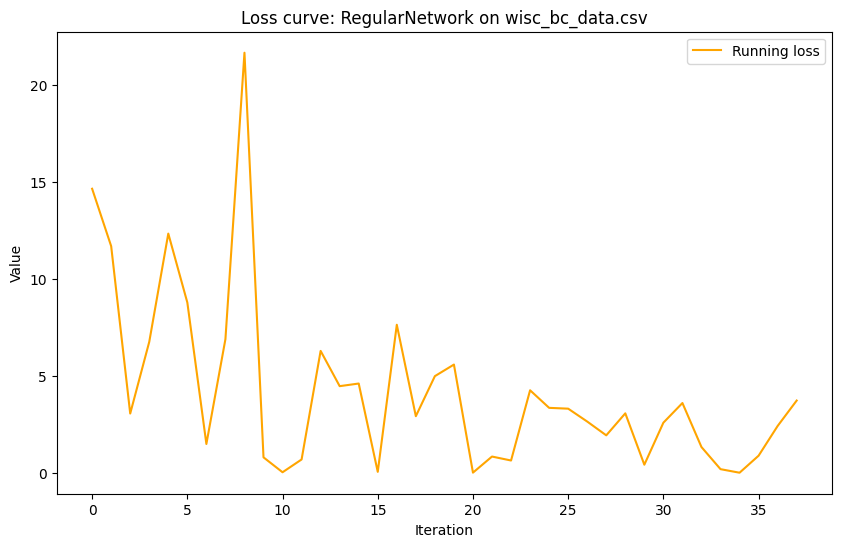

E1/1 S1/38 Loss=0.2031
E1/1 S2/38 Loss=0.1885
E1/1 S3/38 Loss=0.0239
E1/1 S4/38 Loss=0.0298
E1/1 S5/38 Loss=0.0515
E1/1 S6/38 Loss=0.0105
E1/1 S7/38 Loss=0.0541
E1/1 S8/38 Loss=0.0515
E1/1 S9/38 Loss=0.0248
E1/1 S10/38 Loss=0.0017
E1/1 S11/38 Loss=0.0549
E1/1 S12/38 Loss=0.0147
E1/1 S13/38 Loss=0.0433
E1/1 S14/38 Loss=0.0172
E1/1 S15/38 Loss=0.0045
E1/1 S16/38 Loss=0.0058
E1/1 S17/38 Loss=0.0230
E1/1 S18/38 Loss=0.0081
E1/1 S19/38 Loss=0.0051
E1/1 S20/38 Loss=0.0025
E1/1 S21/38 Loss=0.0019
E1/1 S22/38 Loss=0.0122
E1/1 S23/38 Loss=0.0058
E1/1 S24/38 Loss=0.0118
E1/1 S25/38 Loss=0.0044
E1/1 S26/38 Loss=0.0046
E1/1 S27/38 Loss=0.0533
E1/1 S28/38 Loss=0.0224
E1/1 S29/38 Loss=0.0062
E1/1 S30/38 Loss=0.0005
E1/1 S31/38 Loss=0.0003
E1/1 S32/38 Loss=0.0000
E1/1 S33/38 Loss=0.0022
E1/1 S34/38 Loss=0.0456
E1/1 S35/38 Loss=0.0077
E1/1 S36/38 Loss=0.0061
E1/1 S37/38 Loss=0.0079
E1/1 S38/38 Loss=0.0002


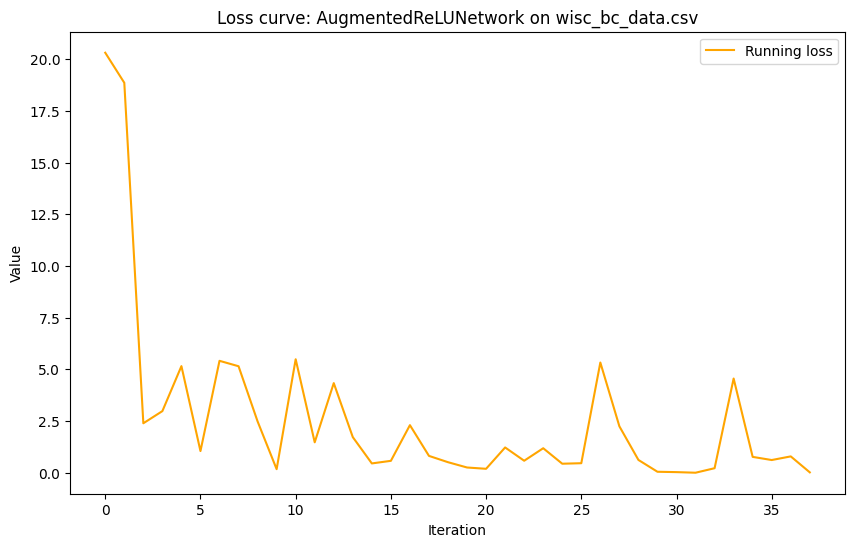

E1/1 S1/116 Loss=0.0140
E1/1 S2/116 Loss=0.0128
E1/1 S3/116 Loss=0.0121
E1/1 S4/116 Loss=0.0108
E1/1 S5/116 Loss=0.0105
E1/1 S6/116 Loss=0.0090
E1/1 S7/116 Loss=0.0117
E1/1 S8/116 Loss=0.0058
E1/1 S9/116 Loss=0.0083
E1/1 S10/116 Loss=0.0120
E1/1 S11/116 Loss=0.0095
E1/1 S12/116 Loss=0.0046
E1/1 S13/116 Loss=0.0084
E1/1 S14/116 Loss=0.0068
E1/1 S15/116 Loss=0.0057
E1/1 S16/116 Loss=0.0071
E1/1 S17/116 Loss=0.0118
E1/1 S18/116 Loss=0.0094
E1/1 S19/116 Loss=0.0081
E1/1 S20/116 Loss=0.0062
E1/1 S21/116 Loss=0.0075
E1/1 S22/116 Loss=0.0050
E1/1 S23/116 Loss=0.0074
E1/1 S24/116 Loss=0.0162
E1/1 S25/116 Loss=0.0091
E1/1 S26/116 Loss=0.0078
E1/1 S27/116 Loss=0.0049
E1/1 S28/116 Loss=0.0055
E1/1 S29/116 Loss=0.0059
E1/1 S30/116 Loss=0.0063
E1/1 S31/116 Loss=0.0040
E1/1 S32/116 Loss=0.0049
E1/1 S33/116 Loss=0.0048
E1/1 S34/116 Loss=0.0064
E1/1 S35/116 Loss=0.0081
E1/1 S36/116 Loss=0.0092
E1/1 S37/116 Loss=0.0075
E1/1 S38/116 Loss=0.0060
E1/1 S39/116 Loss=0.0073
E1/1 S40/116 Loss=0.0104
E1/1 S41/

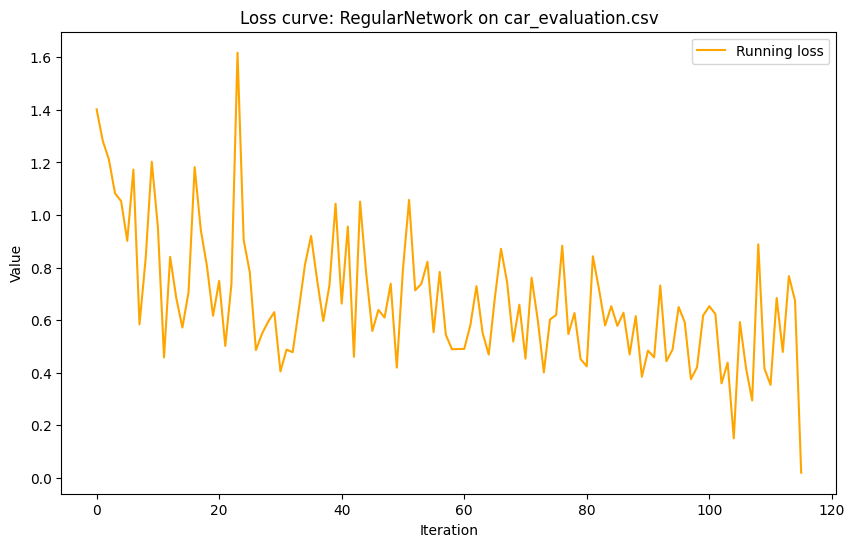

E1/1 S1/116 Loss=0.0143
E1/1 S2/116 Loss=0.0141
E1/1 S3/116 Loss=0.0134
E1/1 S4/116 Loss=0.0127
E1/1 S5/116 Loss=0.0127
E1/1 S6/116 Loss=0.0116
E1/1 S7/116 Loss=0.0106
E1/1 S8/116 Loss=0.0087
E1/1 S9/116 Loss=0.0093
E1/1 S10/116 Loss=0.0077
E1/1 S11/116 Loss=0.0062
E1/1 S12/116 Loss=0.0077
E1/1 S13/116 Loss=0.0080
E1/1 S14/116 Loss=0.0051
E1/1 S15/116 Loss=0.0057
E1/1 S16/116 Loss=0.0101
E1/1 S17/116 Loss=0.0071
E1/1 S18/116 Loss=0.0088
E1/1 S19/116 Loss=0.0108
E1/1 S20/116 Loss=0.0109
E1/1 S21/116 Loss=0.0111
E1/1 S22/116 Loss=0.0137
E1/1 S23/116 Loss=0.0147
E1/1 S24/116 Loss=0.0066
E1/1 S25/116 Loss=0.0047
E1/1 S26/116 Loss=0.0086
E1/1 S27/116 Loss=0.0089
E1/1 S28/116 Loss=0.0086
E1/1 S29/116 Loss=0.0082
E1/1 S30/116 Loss=0.0050
E1/1 S31/116 Loss=0.0073
E1/1 S32/116 Loss=0.0115
E1/1 S33/116 Loss=0.0077
E1/1 S34/116 Loss=0.0098
E1/1 S35/116 Loss=0.0138
E1/1 S36/116 Loss=0.0087
E1/1 S37/116 Loss=0.0061
E1/1 S38/116 Loss=0.0070
E1/1 S39/116 Loss=0.0061
E1/1 S40/116 Loss=0.0102
E1/1 S41/

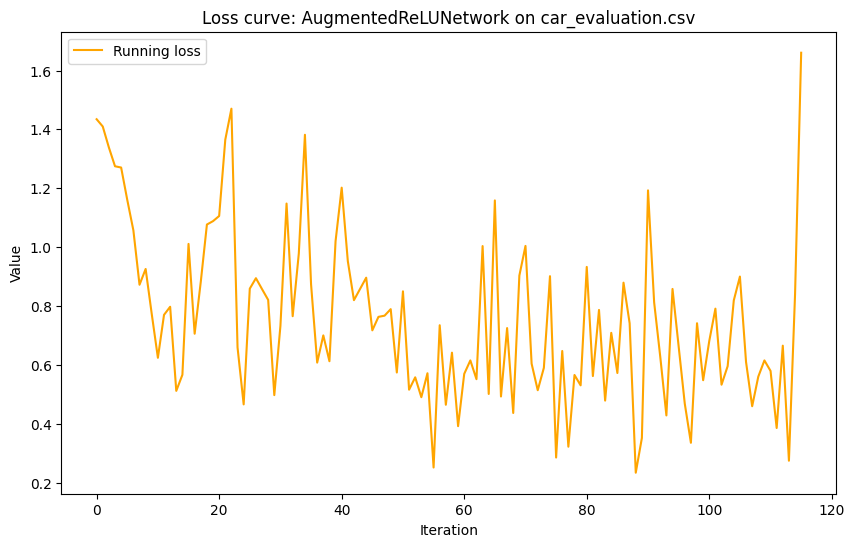

E1/1 S1/436 Loss=49.2759
E1/1 S2/436 Loss=41.2610
E1/1 S3/436 Loss=35.5882
E1/1 S4/436 Loss=30.2028
E1/1 S5/436 Loss=24.9655
E1/1 S6/436 Loss=21.0871
E1/1 S7/436 Loss=16.8376
E1/1 S8/436 Loss=13.9114
E1/1 S9/436 Loss=11.0295
E1/1 S10/436 Loss=8.2704
E1/1 S11/436 Loss=6.0471
E1/1 S12/436 Loss=4.9554
E1/1 S13/436 Loss=3.1964
E1/1 S14/436 Loss=2.4079
E1/1 S15/436 Loss=1.7540
E1/1 S16/436 Loss=0.8260
E1/1 S17/436 Loss=0.2938
E1/1 S18/436 Loss=0.5949
E1/1 S19/436 Loss=0.7382
E1/1 S20/436 Loss=0.7525
E1/1 S21/436 Loss=0.5121
E1/1 S22/436 Loss=1.3975
E1/1 S23/436 Loss=1.5183
E1/1 S24/436 Loss=1.4341
E1/1 S25/436 Loss=1.5784
E1/1 S26/436 Loss=2.2938
E1/1 S27/436 Loss=0.9980
E1/1 S28/436 Loss=2.8932
E1/1 S29/436 Loss=2.2379
E1/1 S30/436 Loss=2.1145
E1/1 S31/436 Loss=1.7921
E1/1 S32/436 Loss=1.0494
E1/1 S33/436 Loss=1.7284
E1/1 S34/436 Loss=1.2058
E1/1 S35/436 Loss=1.8754
E1/1 S36/436 Loss=1.2069
E1/1 S37/436 Loss=1.0170
E1/1 S38/436 Loss=0.3491
E1/1 S39/436 Loss=0.7610
E1/1 S40/436 Loss=0.7358


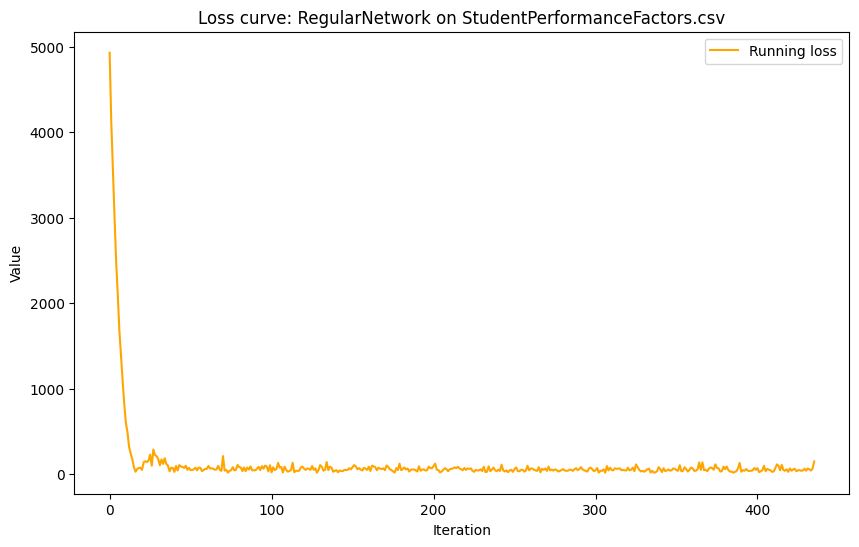

E1/1 S1/436 Loss=47.9516
E1/1 S2/436 Loss=40.7913
E1/1 S3/436 Loss=35.8723
E1/1 S4/436 Loss=30.5362
E1/1 S5/436 Loss=26.7287
E1/1 S6/436 Loss=21.3956
E1/1 S7/436 Loss=18.1711
E1/1 S8/436 Loss=14.3084
E1/1 S9/436 Loss=14.6933
E1/1 S10/436 Loss=9.4065
E1/1 S11/436 Loss=7.2780
E1/1 S12/436 Loss=6.8963
E1/1 S13/436 Loss=3.4541
E1/1 S14/436 Loss=3.1959
E1/1 S15/436 Loss=2.4209
E1/1 S16/436 Loss=1.7123
E1/1 S17/436 Loss=0.9235
E1/1 S18/436 Loss=0.6847
E1/1 S19/436 Loss=0.4428
E1/1 S20/436 Loss=0.7450
E1/1 S21/436 Loss=0.9308
E1/1 S22/436 Loss=0.7109
E1/1 S23/436 Loss=0.8858
E1/1 S24/436 Loss=0.8652
E1/1 S25/436 Loss=1.5534
E1/1 S26/436 Loss=1.1502
E1/1 S27/436 Loss=1.4472
E1/1 S28/436 Loss=1.6891
E1/1 S29/436 Loss=1.7738
E1/1 S30/436 Loss=2.7696
E1/1 S31/436 Loss=2.4532
E1/1 S32/436 Loss=1.2418
E1/1 S33/436 Loss=2.0025
E1/1 S34/436 Loss=1.4567
E1/1 S35/436 Loss=1.7030
E1/1 S36/436 Loss=2.0697
E1/1 S37/436 Loss=0.9400
E1/1 S38/436 Loss=0.9374
E1/1 S39/436 Loss=1.0195
E1/1 S40/436 Loss=1.1822


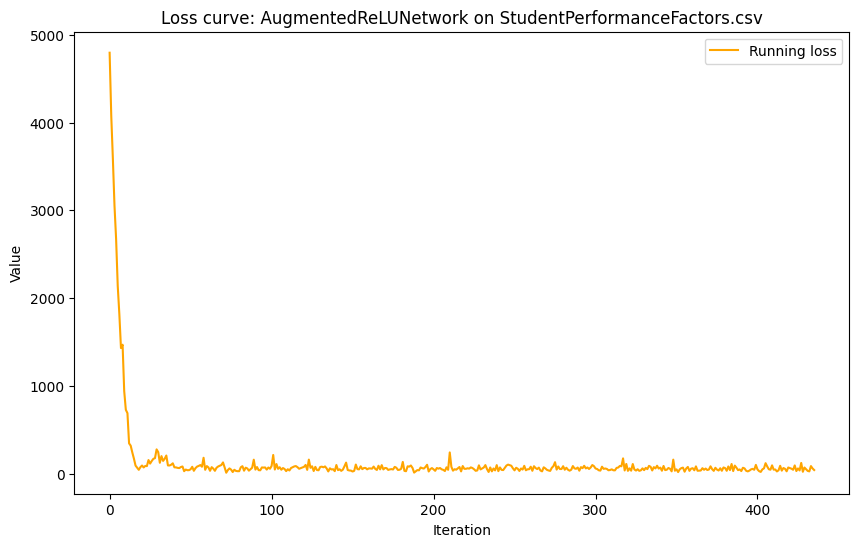

In [110]:
def train_pair_of_networks(
    criterion: nn.CrossEntropyLoss | nn.MSELoss,
    dataset: Dataset,
    learning_rate: float,
    epochs: int,
    params: ExperimentParameters,
    model_a_name: str,
    model_b_name: str
):
    modelA = RegularNetwork(
        inputs_count=dataset.features_count,
        outputs_count=dataset.classes_count,
        p=params.p
    )

    modelA.apply(init_weights)

    train(
        model=modelA,
        dataset=dataset,
        epochs=epochs,
        params=params,
        criterion=criterion,
        optimizer=optim.Adam(
            modelA.parameters(),
            lr=learning_rate
        )
    )

    torch.save(modelA.state_dict(), model_a_name)

    modelB = AugmentedReLUNetwork(
        inputs_count=dataset.features_count,
        outputs_count=dataset.classes_count,
        p=params.p
    )

    modelB.apply(init_weights)

    train(
        model=modelB,
        dataset=dataset,
        epochs=epochs,
        params=params,
        criterion=criterion,
        optimizer=optim.Adam(
            modelB.parameters(),
            lr=learning_rate
        )
    )

    torch.save(modelB.state_dict(), model_b_name)

for experiment_params in experiment_parameters():
    train_pair_of_networks(
        classification_task.criterion,
        datasets[0],
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        params=experiment_params,
        model_a_name=datasets[0].model_a_path(experiment_params),
        model_b_name=datasets[0].model_b_path(experiment_params),
    )

    train_pair_of_networks(
        classification_task.criterion,
        datasets[1],
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        params=experiment_params,
        model_a_name=datasets[1].model_a_path(experiment_params),
        model_b_name=datasets[1].model_b_path(experiment_params),
    )

    train_pair_of_networks(
        regression_task.criterion,
        datasets[2],
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        params=experiment_params,
        model_a_name=datasets[2].model_a_path(experiment_params),
        model_b_name=datasets[2].model_b_path(experiment_params),
    )


In [117]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, r2_score, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def positive_probs_from(probs: torch.Tensor) -> list:
    return np.array(probs)[:, 0]

def evaluate_classification_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    noise_factor: float,
    p: float,
    is_binary_classification: bool,
    inputs_count: int,
    outputs_count: int
) -> tuple[float, float, float]:
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count,
        p=p
    )

    print(f'Loading state dict at {model_path}')
    evaluated_model.load_state_dict(torch.load(model_path))

    evaluated_model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataset.data.test_loader:
            outputs = evaluated_model(
                inputs + torch.randn(inputs.shape) * noise_factor
            )
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if is_binary_classification:
        all_probs = np.array(all_probs)[:, 0]

    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return float(accuracy), float(f1), float(roc_auc)

def evaluate_regression_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    noise_factor: float,
    p: float,
    inputs_count: int,
    outputs_count: int
) -> tuple[float, float]:
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count,
        p=p
    )

    print(f'Loading state dict at {model_path}')
    evaluated_model.load_state_dict(torch.load(model_path))

    evaluated_model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataset.data.test_loader:
            noisy_inputs = inputs + torch.randn(inputs.shape) * noise_factor
            outputs = evaluated_model(noisy_inputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    r2 = r2_score(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)

    return float(r2), float(mse)

def evaluate_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    is_binary_classification: bool,
    is_regression: bool,
    inputs_count: int,
    outputs_count: int,
    params: ExperimentParameters
)-> pd.DataFrame:
    if is_regression:
        samples = {
            'noise_factor': NOISE_FACTORS,
            'r2': [],
            'mse': [],
        }

        for noise_factor in NOISE_FACTORS:
            r2, mse = evaluate_regression_model(
                dataset=dataset,
                model_path=model_path,
                constructor=constructor,
                noise_factor=noise_factor,
                p=p,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['r2'].append(r2)
            samples['mse'].append(mse)

        append_to_report(f'evaluate_{model_path}_p{params.p}_N{params.iteration}', samples)
        return pd.DataFrame(samples)
    else:
        samples = {
            'noise_factor': NOISE_FACTORS,
            'accuracy': [],
            'f1': [],
            'roc_auc': [],
        }

        for noise_factor in NOISE_FACTORS:
            accuracy, f1, roc_auc = evaluate_classification_model(
                dataset=dataset,
                model_path=model_path,
                constructor=constructor,
                noise_factor=noise_factor,
                p=p,
                is_binary_classification=is_binary_classification,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['accuracy'].append(accuracy)
            samples['f1'].append(f1)
            samples['roc_auc'].append(roc_auc)

        append_to_report(f'evaluate_{model_path}_p{params.p}_N{params.iteration}', samples)
        return pd.DataFrame(samples)

def plot_evaluation_of_classification(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['accuracy'], label='Accuracy', marker='o')
    plt.plot(df['noise_factor'], df['f1'], label='F1 Score', marker='o')
    plt.plot(df['noise_factor'], df['roc_auc'], label='ROC AUC', marker='o')

    plt.xscale('log')
    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor: {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

# XXX split into two..
def plot_evaluation_of_regression(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['mse'], label='Mean Square Error', marker='o')

    # plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor: {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")

    plt.show()

    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['r2'], label='R^2', marker='o')

    # plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P0.05_N0.pth
Loading state dict at model-1A-c-P

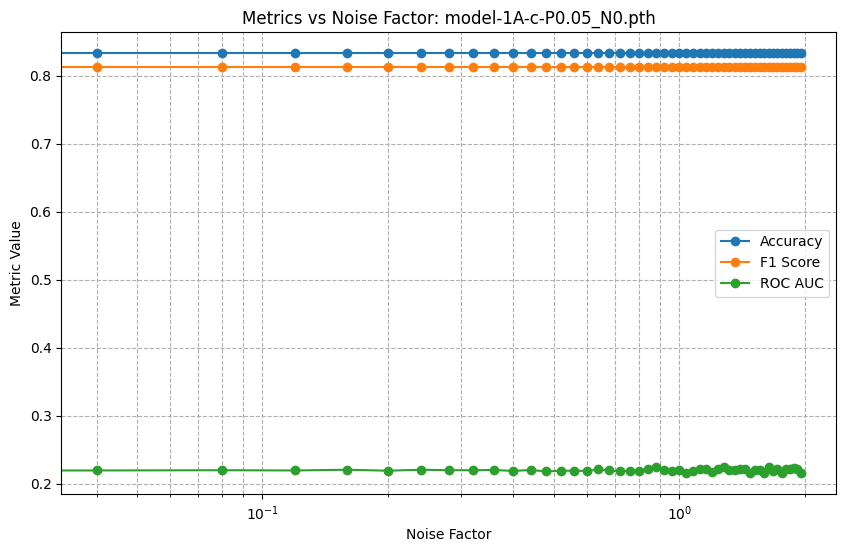

Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P0.05_N0.pth
Loading state dict at model-2A-c-P

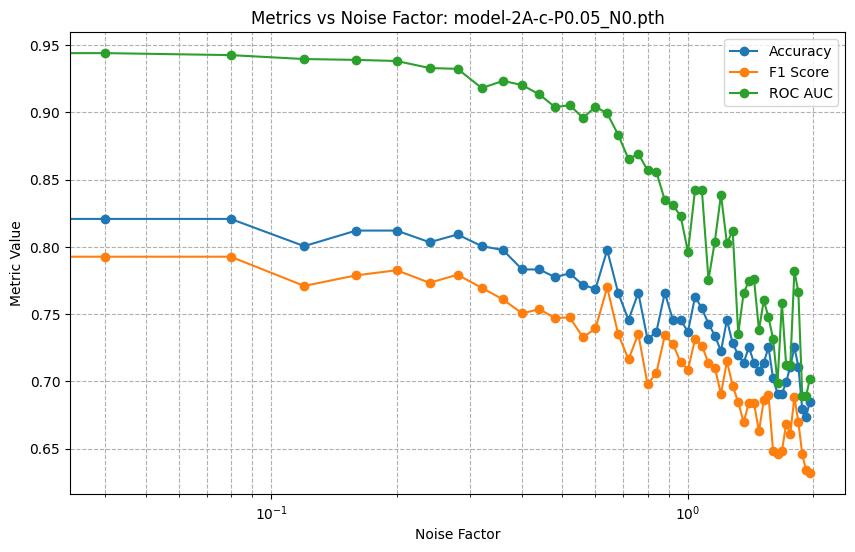

Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P0.05_N0.pth
Loading state dict at model-3A-c-P

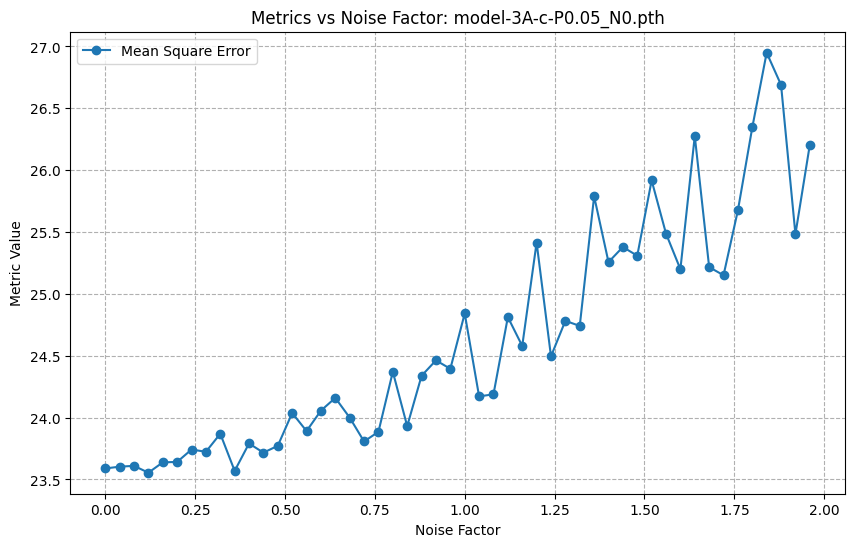

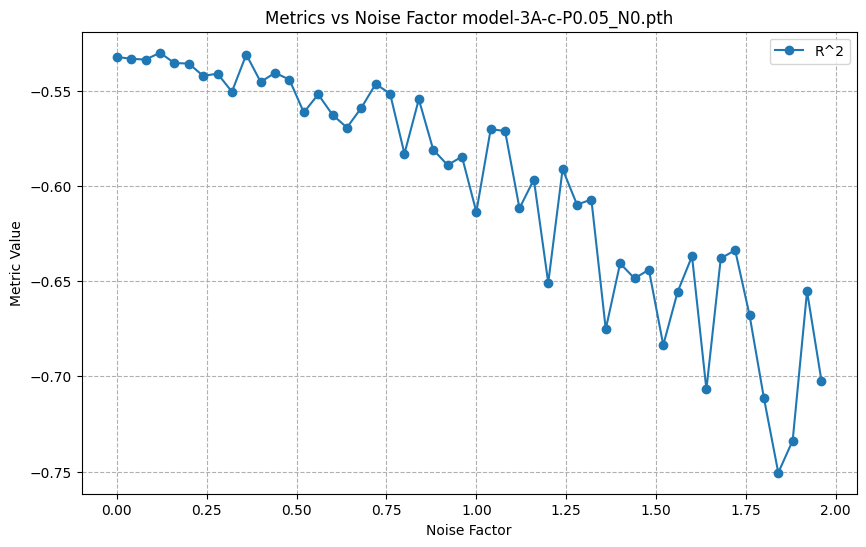

Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P0.05_N0.pth
Loading state dict at model-1B-c-P

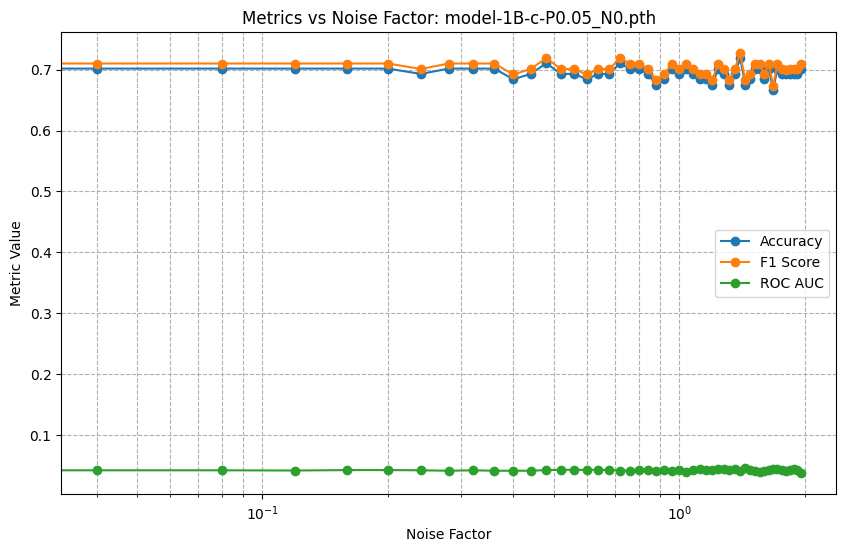

Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P0.05_N0.pth
Loading state dict at model-2B-c-P

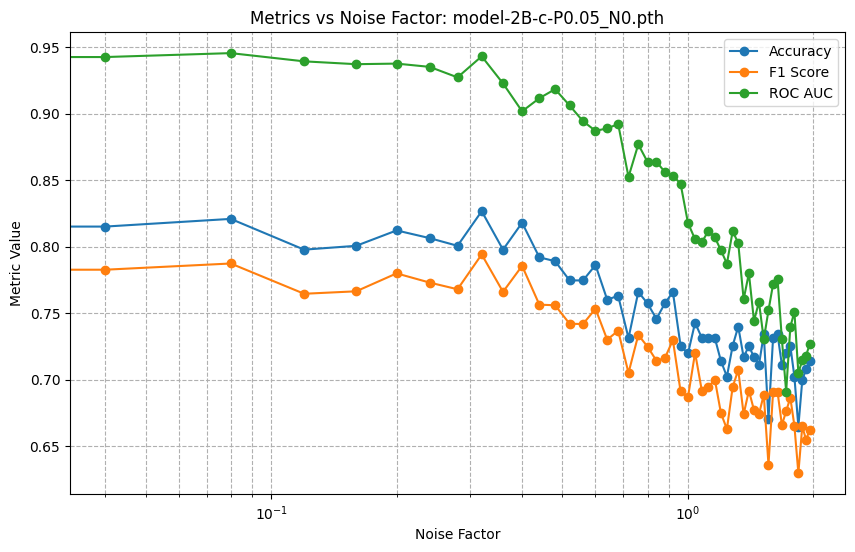

Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P0.05_N0.pth
Loading state dict at model-3B-c-P

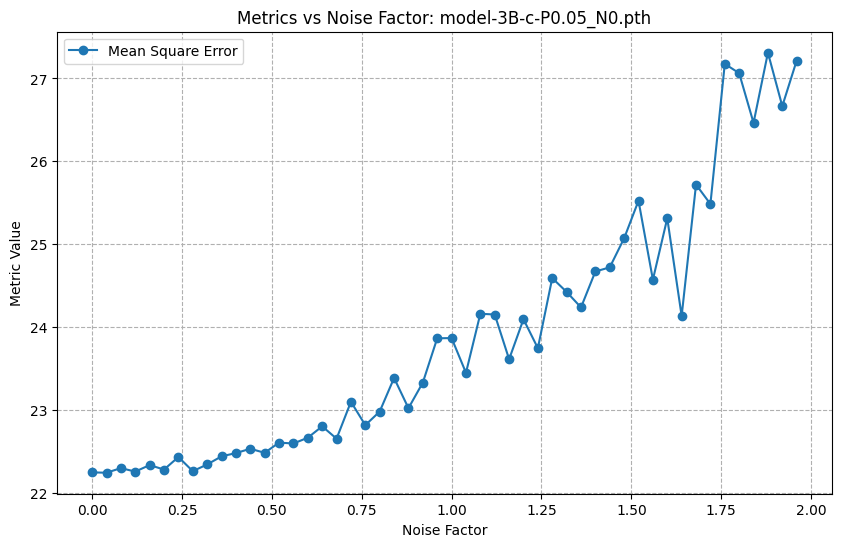

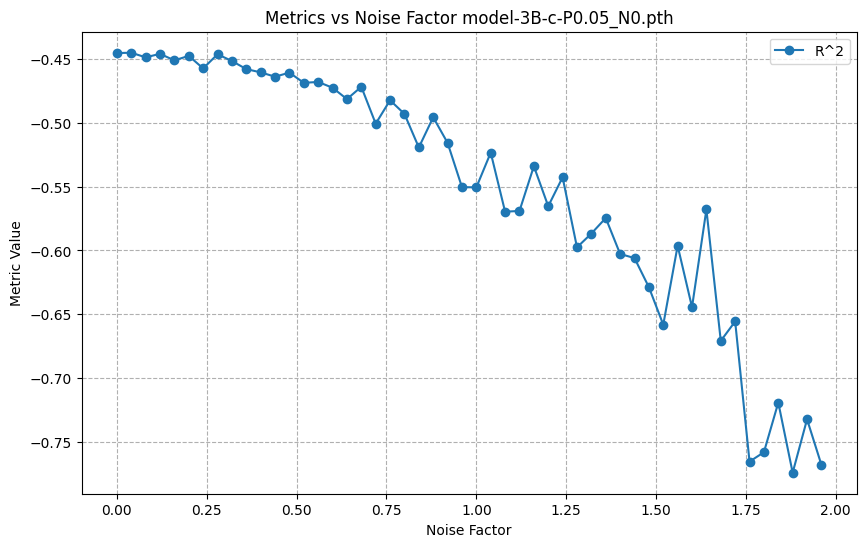

Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading state dict at model-1A-c-P0.5_N0.pth
Loading st

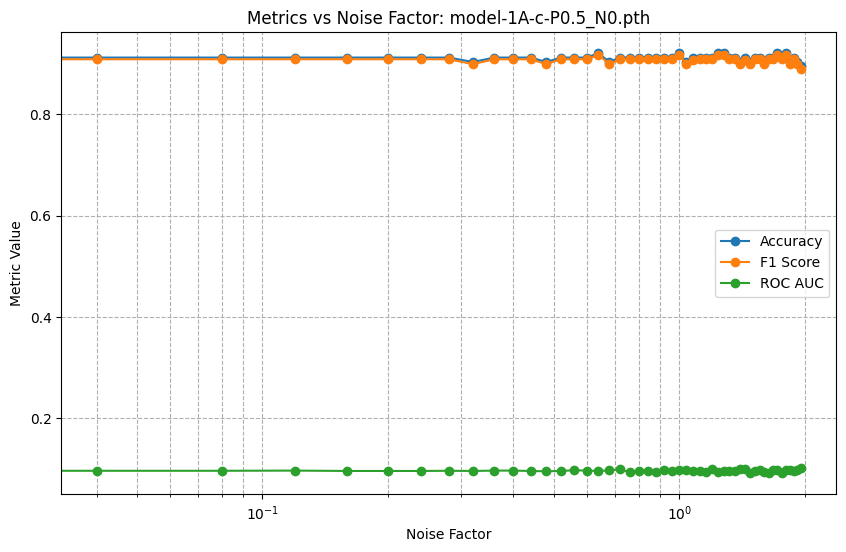

Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading state dict at model-2A-c-P0.5_N0.pth
Loading st

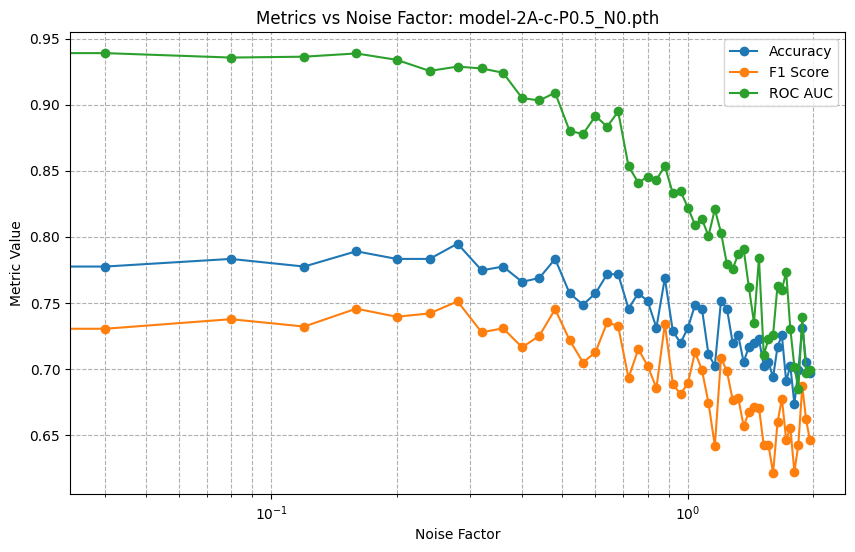

Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading state dict at model-3A-c-P0.5_N0.pth
Loading st

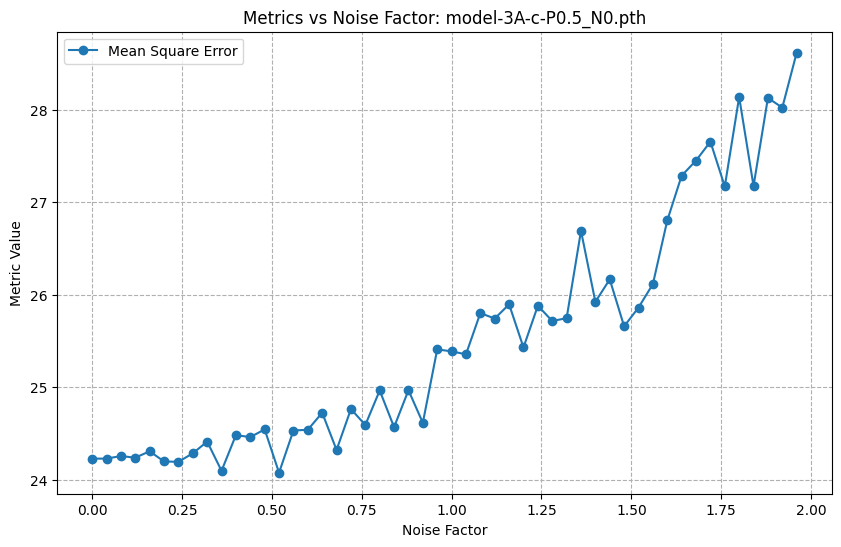

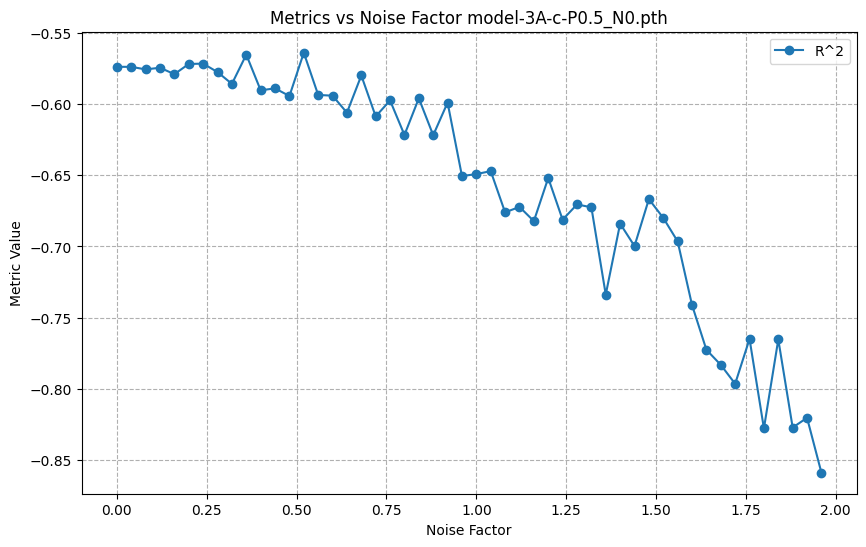

Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading state dict at model-1B-c-P0.5_N0.pth
Loading st

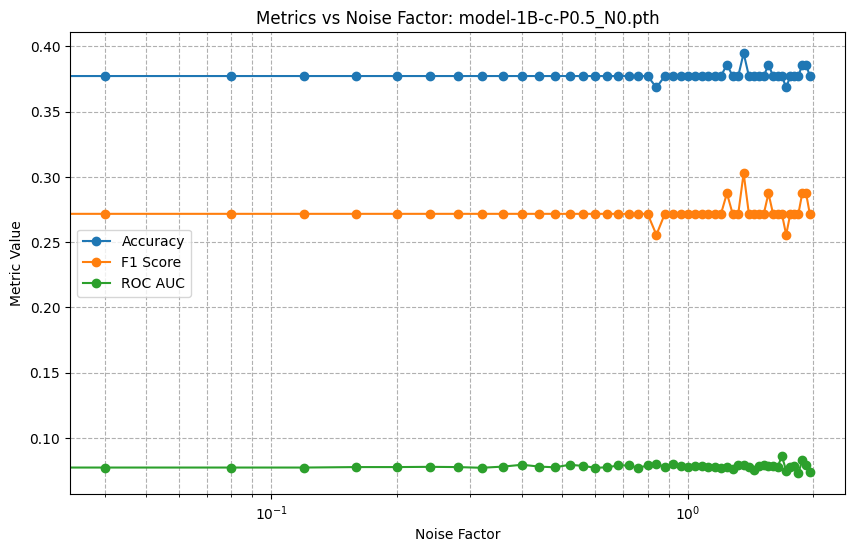

Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading state dict at model-2B-c-P0.5_N0.pth
Loading st

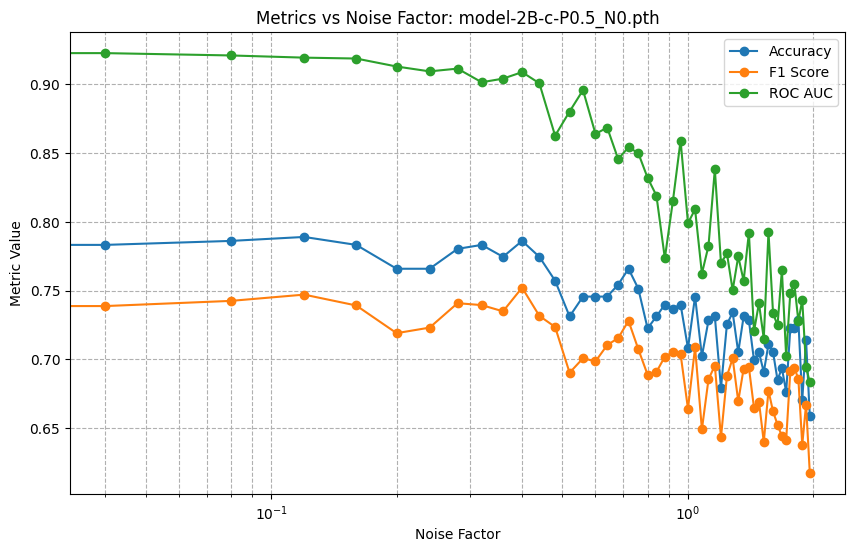

Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading state dict at model-3B-c-P0.5_N0.pth
Loading st

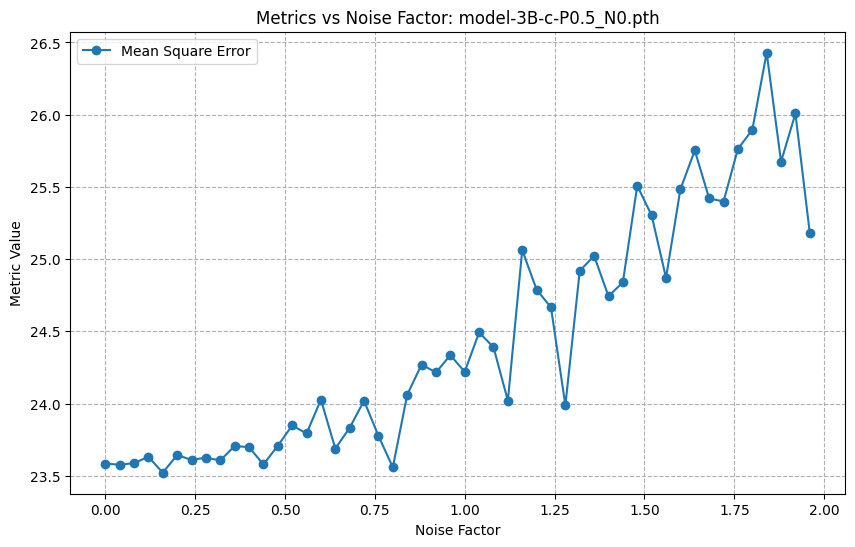

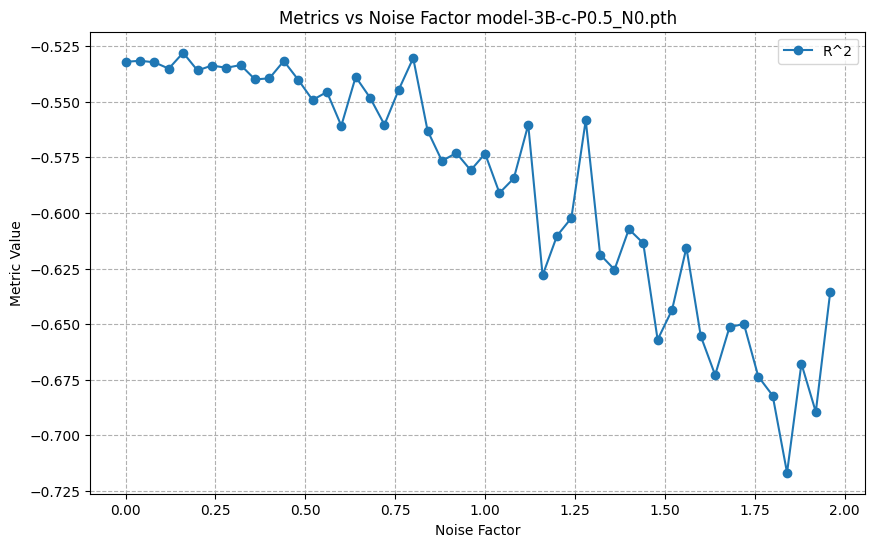

Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P0.05_N1.pth
Loading state dict at model-1A-c-P

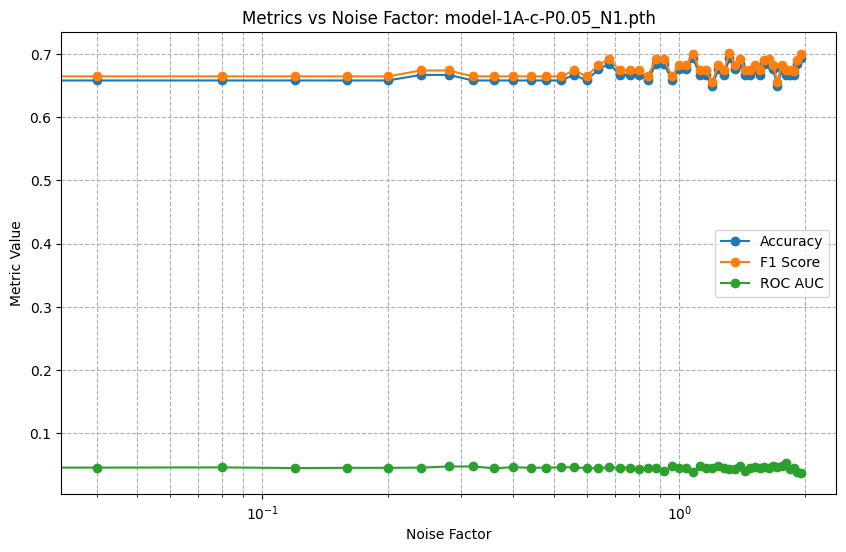

Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P0.05_N1.pth
Loading state dict at model-2A-c-P

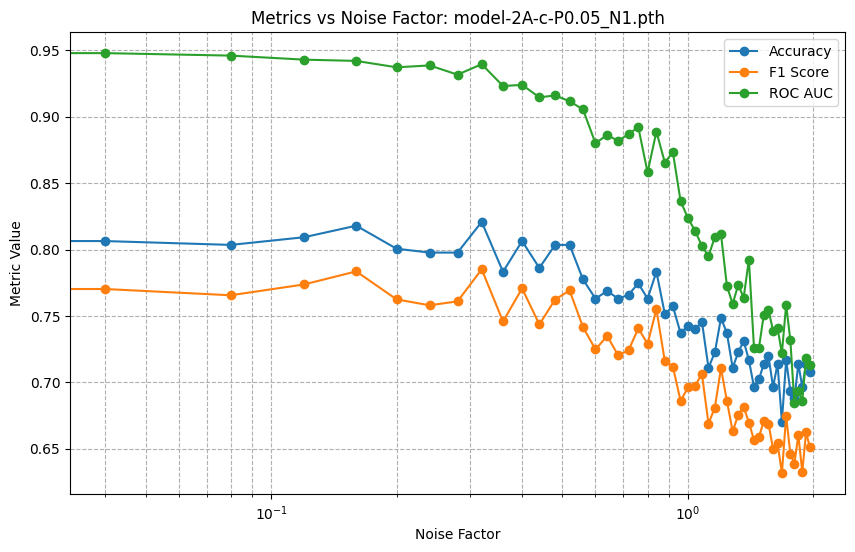

Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P0.05_N1.pth
Loading state dict at model-3A-c-P

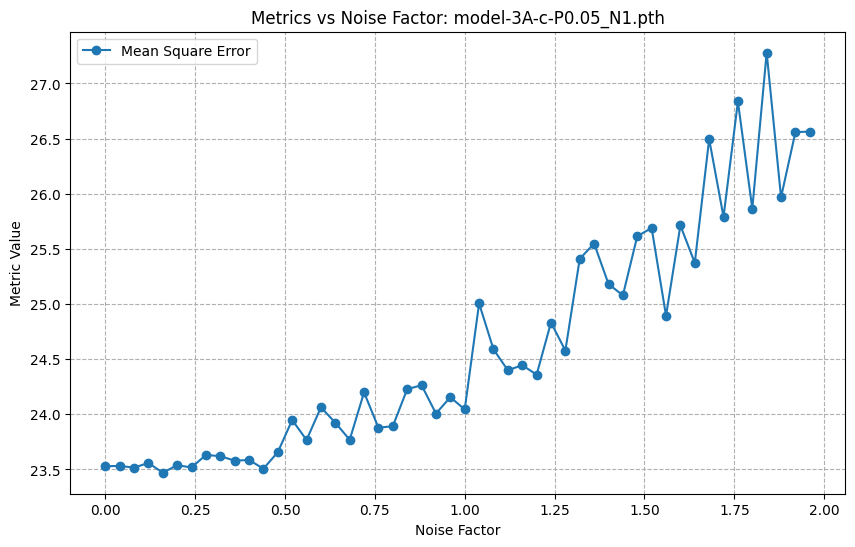

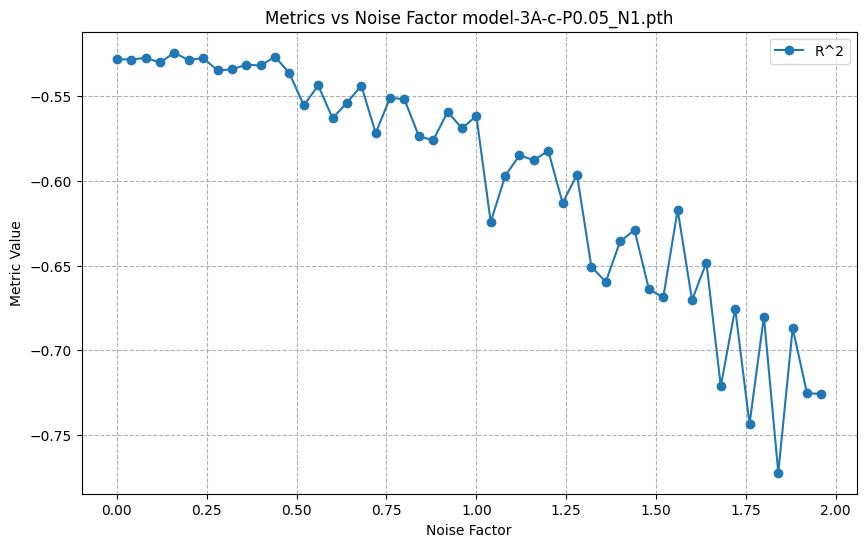

Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P0.05_N1.pth
Loading state dict at model-1B-c-P

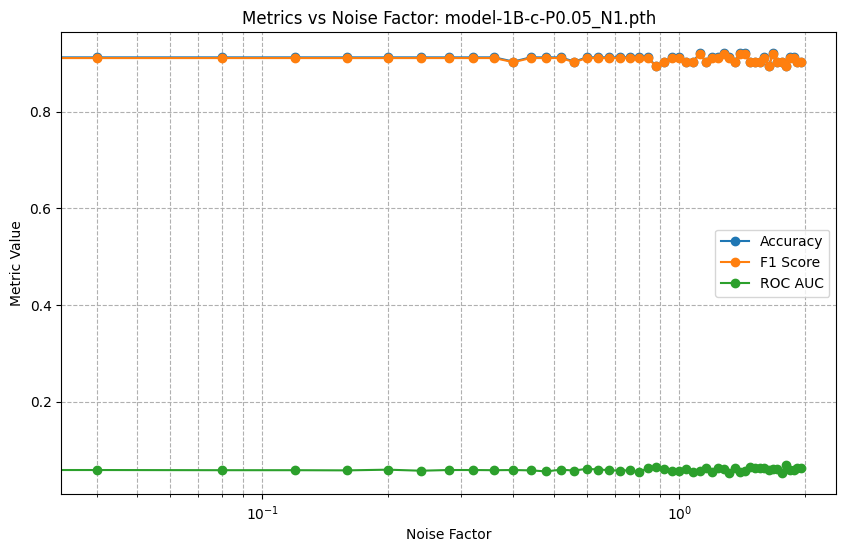

Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P0.05_N1.pth
Loading state dict at model-2B-c-P

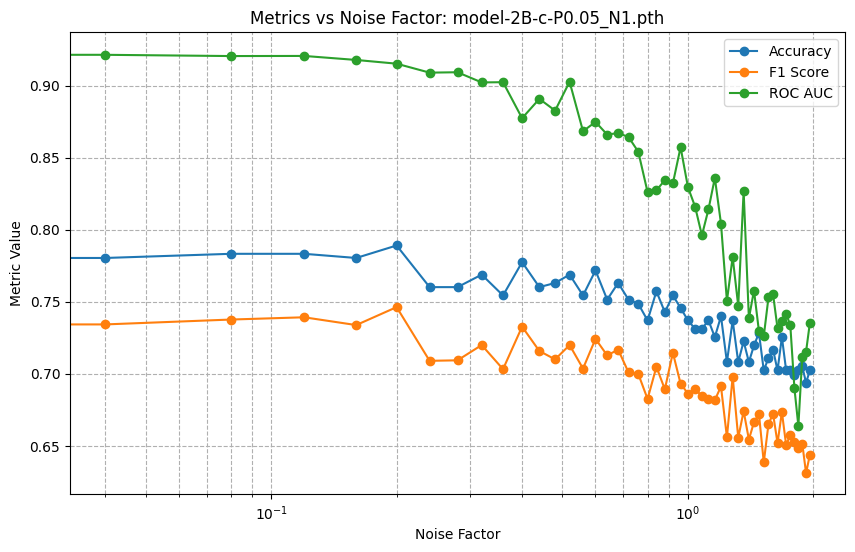

Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P0.05_N1.pth
Loading state dict at model-3B-c-P

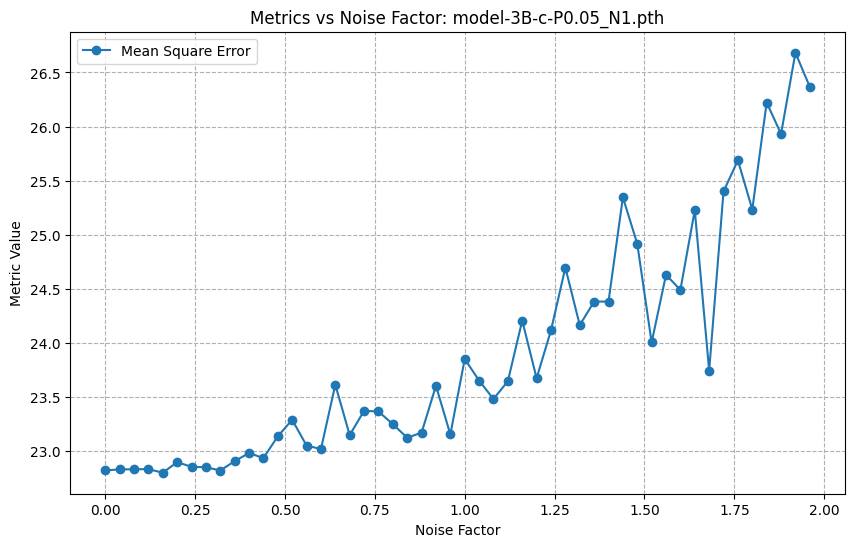

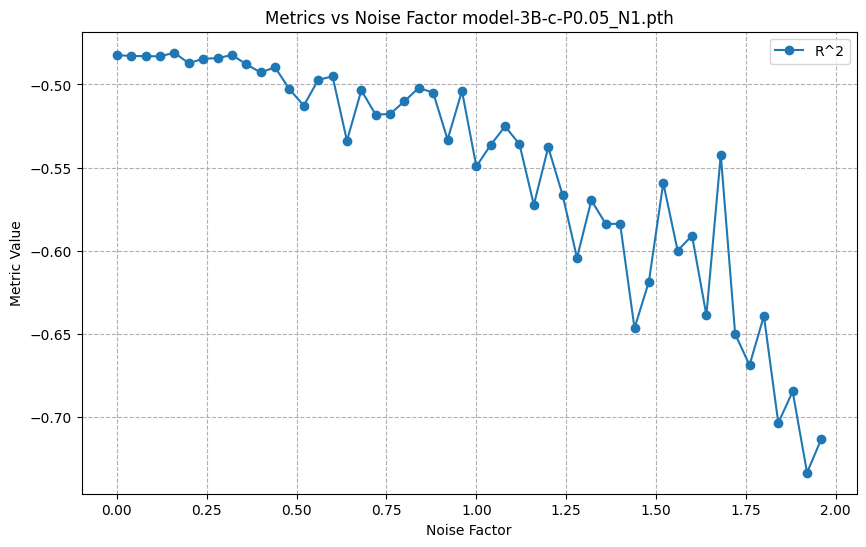

Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading state dict at model-1A-c-P0.5_N1.pth
Loading st

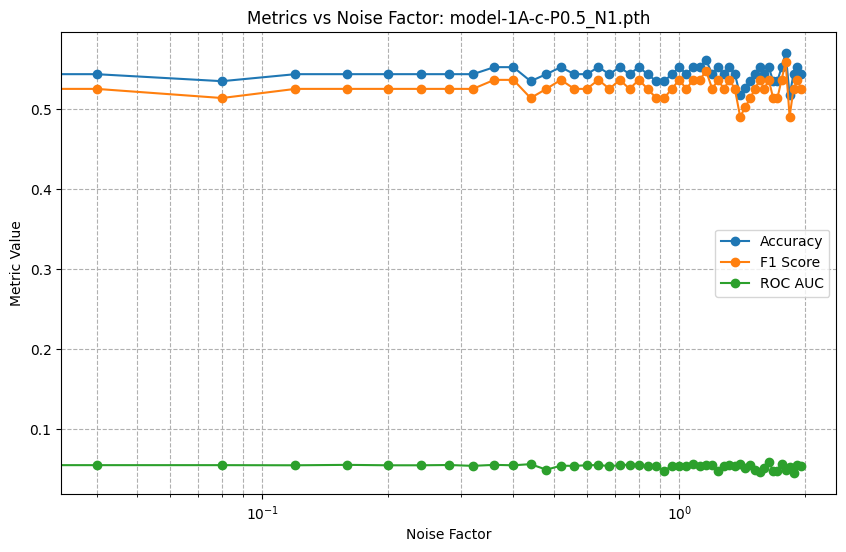

Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading state dict at model-2A-c-P0.5_N1.pth
Loading st

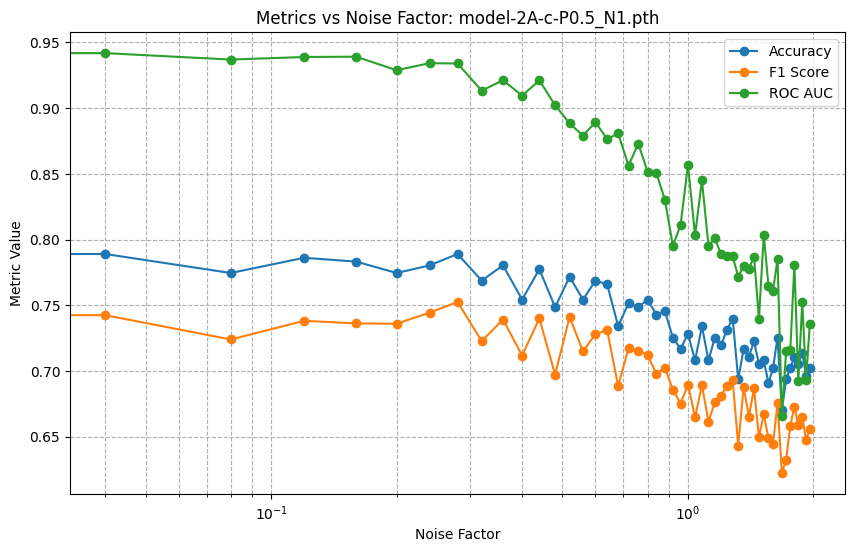

Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading state dict at model-3A-c-P0.5_N1.pth
Loading st

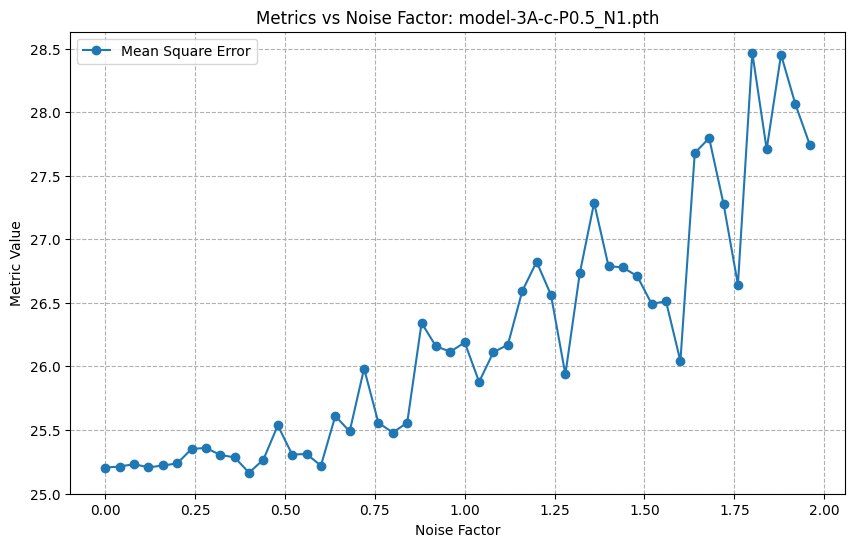

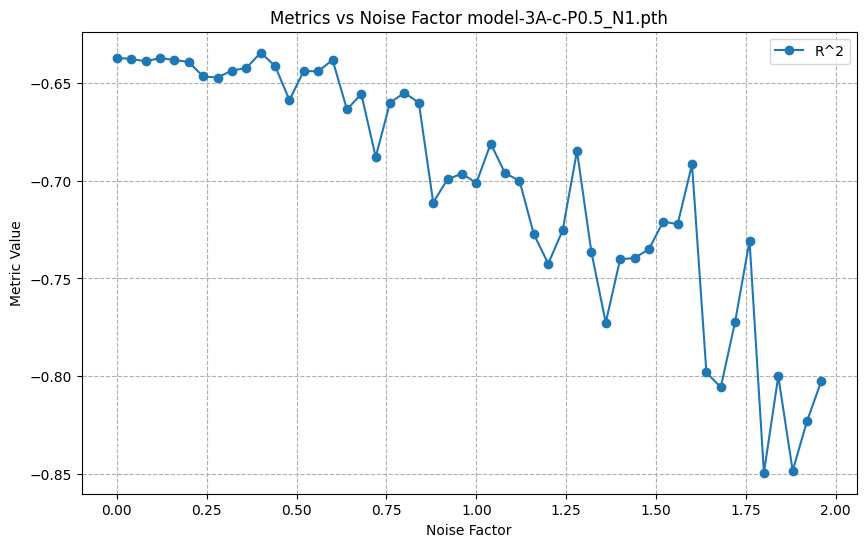

Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading state dict at model-1B-c-P0.5_N1.pth
Loading st

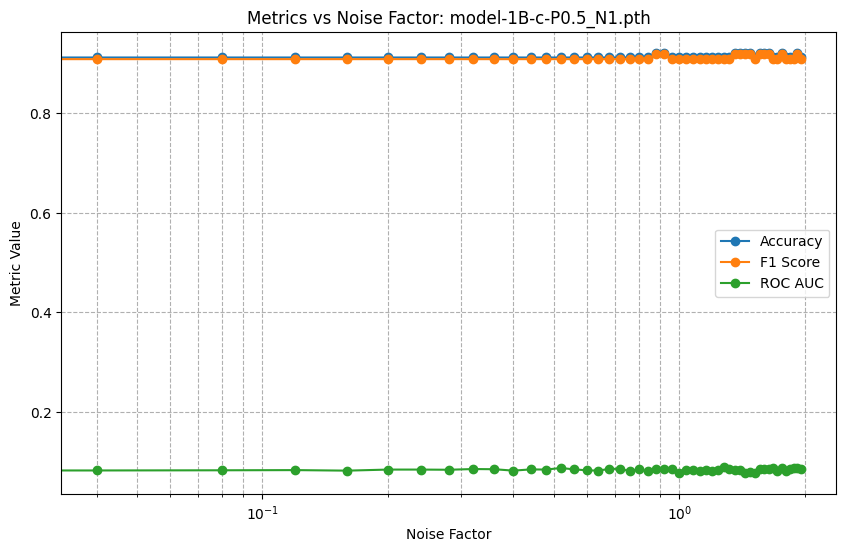

Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading state dict at model-2B-c-P0.5_N1.pth
Loading st

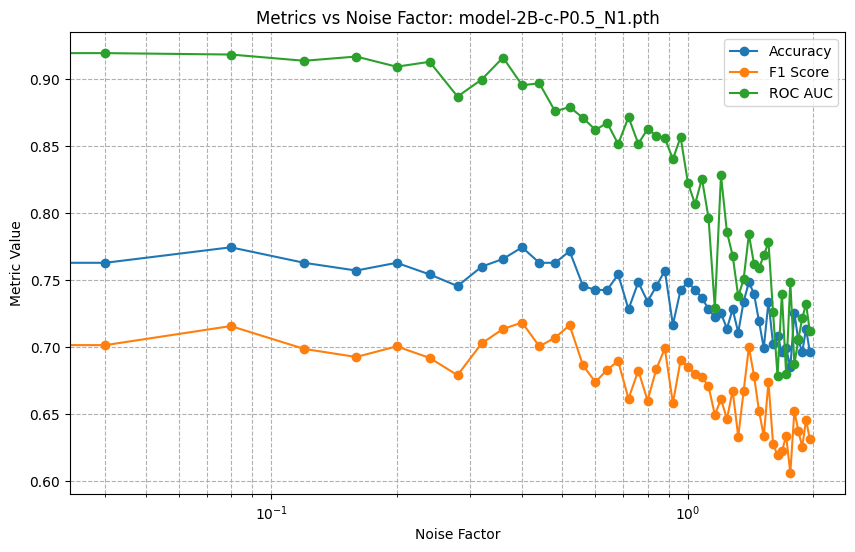

Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading state dict at model-3B-c-P0.5_N1.pth
Loading st

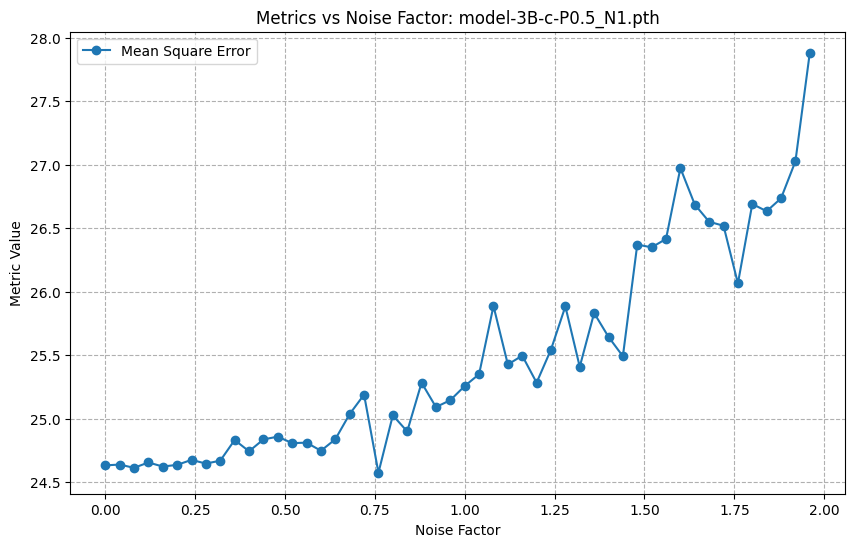

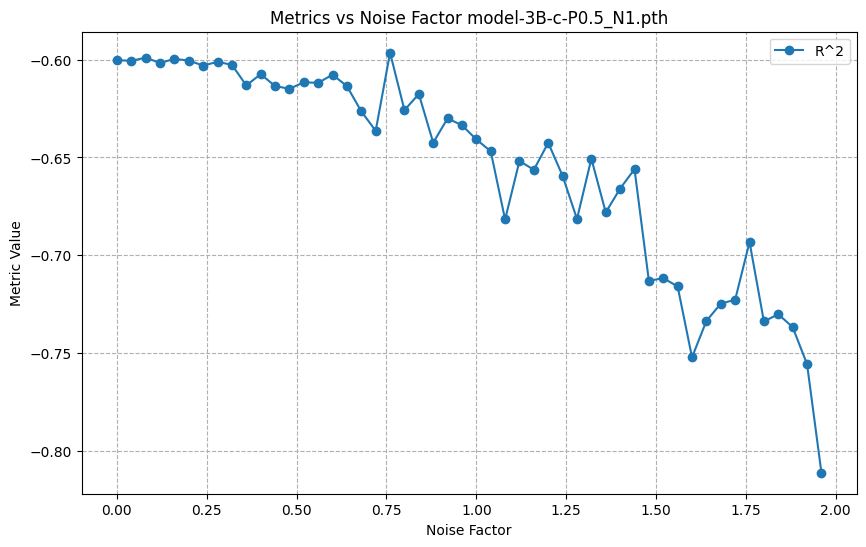

Отчёт сохранён в report/report.json


In [119]:
@dataclass
class EvaluationParameters:
    dataset: Dataset
    model_path: str
    is_binary_classification: bool
    is_regression: bool
    inputs_count: int
    outputs_count: int
    task: LearningTask
    experiment_params: ExperimentParameters

def evaluate(
    model_a_or_b: str,
    constructor: type,
    experiment_params: EvaluationParameters
):
    
    def model_path_for(
        model_a_or_b: str,
        dataset: Dataset
    ):
        if model_a_or_b == 'A':
            return dataset.model_a_path(experiment_params)
        elif model_a_or_b == 'B':
            return dataset.model_b_path(experiment_params)
        else:
            raise TypeError('model_a_or_b must be A or B')
    
    eval_params_items: list[EvaluationParameters] = [
        EvaluationParameters(
            dataset=datasets[0],
            model_path=model_path_for(model_a_or_b, datasets[0]),
            is_binary_classification=True,
            is_regression=False,
            inputs_count=30,
            outputs_count=2,
            task=classification_task,
            experiment_params=experiment_params
        ),
        EvaluationParameters(
            dataset=datasets[1],
            model_path=model_path_for(model_a_or_b, datasets[1]),
            is_binary_classification=False,
            is_regression=False,
            inputs_count=6,
            outputs_count=4,
            task=classification_task,
            experiment_params=experiment_params
        ),
        EvaluationParameters(
            dataset=datasets[2],
            model_path=model_path_for(model_a_or_b, datasets[2]),
            is_binary_classification=False,
            is_regression=True,
            inputs_count=19,
            outputs_count=1,
            task=regression_task,
            experiment_params=experiment_params
        ),
    ]

    for eval_params in eval_params_items:
        if eval_params.task == classification_task:
            plot_evaluation_of_classification(evaluate_model(
                dataset=eval_params.dataset,
                model_path=eval_params.model_path,
                constructor=constructor,
                is_binary_classification=eval_params.is_binary_classification,
                is_regression=eval_params.is_regression,
                inputs_count=eval_params.inputs_count,
                outputs_count=eval_params.outputs_count,
                params=experiment_params
            ), title=eval_params.model_path)
        elif eval_params.task == regression_task:
            plot_evaluation_of_regression(evaluate_model(
                dataset=eval_params.dataset,
                model_path=eval_params.model_path,
                constructor=constructor,
                is_binary_classification=eval_params.is_binary_classification,
                is_regression=eval_params.is_regression,
                inputs_count=eval_params.inputs_count,
                outputs_count=eval_params.outputs_count,
                params=experiment_params
            ), title=eval_params.model_path)

for params in experiment_parameters():
    evaluate('A', RegularNetwork, params)
    evaluate('B', AugmentedReLUNetwork, params)

save_report()